In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3
!pip install torch
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, notebook

from torch.nn import init

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit,StratifiedKFold
import random
import gc
import unicodedata

gc.collect()

In [ ]:
############################################################################
############################################################################
############################################################################

##GPU 사용 시
# there are totally five GPU in server,we can routed to 0:4.
device = torch.device("cuda:4")
gc.collect()

bertmodel, vocab = get_pytorch_kobert_model()

tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx,label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        
        self.sentences = []
        self.labels = []
#         for i in dataset:
#             self.sentences.append(transform([i[sent_idx]]))
#             self.labels.append(i[label_idx])
        for i in dataset:
            if len(i[sent_idx])<=max_len:
                self.sentences.append(transform([i[sent_idx]]))
                self.labels.append(i[label_idx])
            else:
                self.sentences.append(transform([i[sent_idx][:max_len]]))
                self.labels.append(i[label_idx])
        

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))
    
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=11,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
# define parameter
max_len = 512
batch_size = 6
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 20
learning_rate =  5e-6  #5e-5  2e-5
num_workers = 2
n_splits = 5
model_name = 'kobertbest_512.pt'

device = torch.device("cuda:4")

model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
# torch.save(model, 'kobert.pt')

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
torch.save({'modelA':model.state_dict(),'optimizerA':optimizer.state_dict()},'kobert.pt')

loss_fn = nn.CrossEntropyLoss()

def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

##################################################################################################
# train test validate split

# df_raw = pd.read_csv("extract100datasetmanual.csv?dl=1")
# df_raw = pd.read_csv("dataset200_12manually.csv")

#df_raw = pd.read_csv("12classesdatsetnew.csv",index_col=False )

df_raw = pd.read_excel('11classesdatsetnew_20220208.xlsx', engine='openpyxl', sheet_name="classesdatsetnew", header=0)

# df_raw = pd.read_csv("dataset200_13manually2.csv")
# print(df_raw)
# categorylist = ["화장품","핫플레이스","요리음식","여행아웃도어","인테리어","엔터테인먼트"]
categorylist = ["화장품","패션","요리음식","여행아웃도어","인테리어","엔터테인먼트","육아","아이티","자동차","헬스/피트니스","반려동물"]
temp_label=[]
for i in df_raw['label']:
    temp_label.append(categorylist.index(i))
df_raw['label']=temp_label

train_test_ratio = 0.8
df_train_list =[None]*11
df_test_list = [None]*11

df_file =[None] *11

for i, labeli in enumerate(range(len(categorylist))):
    df_file[i] = df_raw[df_raw['label'] == labeli]

for i, dffilei in enumerate(df_file):
    df_train_list[i],df_test_list[i] = train_test_split(dffilei,train_size = train_test_ratio, random_state = 1)

df_train = pd.concat([trainlist for trainlist in df_train_list],ignore_index=True,sort=False)
df_test = pd.concat([dftest for dftest in df_test_list],ignore_index=True,sort=False)

import re

df_traindata = df_train.reindex(columns=['label', 'caption'])
# df_traindata = df_train.reindex(columns=['label', 'hashtag'])
# print(df_traindata)
df_trainlabel = df_train.reindex(columns=['label'])
np_data = df_traindata.to_numpy()
np_label = df_trainlabel.to_numpy()

for i in range(len(np_data)):
    np_data[i][1] = unicodedata.normalize('NFC',np_data[i][1])
    np_data[i][1] = ' '.join(re.compile('[가-힣]+').findall(np_data[i][1]))

df_testdata = df_test.reindex(columns=['label', 'caption'])
# df_testdata = df_test.reindex(columns=['label', 'hashtag'])
df_testlabel = df_test.reindex(columns=['label'])
np_testdata = df_testdata.to_numpy()
np_testlabel = df_testlabel.to_numpy()

for i in range(len(np_testdata)):
    np_testdata[i][1] = unicodedata.normalize('NFC',np_testdata[i][1])
    np_testdata[i][1] = ' '.join(re.compile('[가-힣]+').findall(np_testdata[i][1]))

print(np_testdata)


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/254 Cost: 2.497737 Train Acc 0.0
Epoch 1/20 Batch 21/254 Cost: 2.564185 Train Acc 0.07936507936507937
Epoch 1/20 Batch 41/254 Cost: 2.697651 Train Acc 0.08130081300813007
Epoch 1/20 Batch 61/254 Cost: 2.412825 Train Acc 0.08196721311475408
Epoch 1/20 Batch 81/254 Cost: 2.253788 Train Acc 0.10082304526748971
Epoch 1/20 Batch 101/254 Cost: 2.296819 Train Acc 0.09735973597359732
Epoch 1/20 Batch 121/254 Cost: 2.441181 Train Acc 0.10192837465564727
Epoch 1/20 Batch 141/254 Cost: 2.358121 Train Acc 0.10638297872340415
Epoch 1/20 Batch 161/254 Cost: 2.481853 Train Acc 0.10351966873705994
Epoch 1/20 Batch 181/254 Cost: 2.522463 Train Acc 0.10128913443830566
Epoch 1/20 Batch 201/254 Cost: 2.696386 Train Acc 0.10199004975124377
Epoch 1/20 Batch 221/254 Cost: 2.390479 Train Acc 0.10633484162895931
Epoch 1/20 Batch 241/254 Cost: 2.284411 Train Acc 0.10580912863070545

Epoch 1/20 Cost: 2.514304 Train Acc 0.10695538057742791


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.514304 Test Acc 0.14843749999999994


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/254 Cost: 2.392919 Train Acc 0.0
Epoch 2/20 Batch 21/254 Cost: 2.565944 Train Acc 0.11111111111111109
Epoch 2/20 Batch 41/254 Cost: 2.112586 Train Acc 0.13414634146341461
Epoch 2/20 Batch 61/254 Cost: 2.329468 Train Acc 0.133879781420765
Epoch 2/20 Batch 81/254 Cost: 2.368247 Train Acc 0.1460905349794238
Epoch 2/20 Batch 101/254 Cost: 2.121619 Train Acc 0.1534653465346534
Epoch 2/20 Batch 121/254 Cost: 2.186939 Train Acc 0.16115702479338836
Epoch 2/20 Batch 141/254 Cost: 2.352280 Train Acc 0.1773049645390071
Epoch 2/20 Batch 161/254 Cost: 1.828950 Train Acc 0.19979296066252591
Epoch 2/20 Batch 181/254 Cost: 2.022279 Train Acc 0.210865561694291
Epoch 2/20 Batch 201/254 Cost: 2.025701 Train Acc 0.23134328358208953
Epoch 2/20 Batch 221/254 Cost: 1.981249 Train Acc 0.24509803921568626
Epoch 2/20 Batch 241/254 Cost: 1.912186 Train Acc 0.27524204702627936

Epoch 2/20 Cost: 1.655356 Train Acc 0.2933070866141732


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 2/20 Cost: 1.655356 Test Acc 0.7578124999999998


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/254 Cost: 1.893871 Train Acc 0.3333333333333333
Epoch 3/20 Batch 21/254 Cost: 1.824523 Train Acc 0.7063492063492064
Epoch 3/20 Batch 41/254 Cost: 1.545508 Train Acc 0.7357723577235772
Epoch 3/20 Batch 61/254 Cost: 1.569769 Train Acc 0.7513661202185793
Epoch 3/20 Batch 81/254 Cost: 1.329203 Train Acc 0.7510288065843622
Epoch 3/20 Batch 101/254 Cost: 1.637062 Train Acc 0.7755775577557753
Epoch 3/20 Batch 121/254 Cost: 1.231437 Train Acc 0.7878787878787876
Epoch 3/20 Batch 141/254 Cost: 1.393904 Train Acc 0.7931442080378244
Epoch 3/20 Batch 161/254 Cost: 1.651862 Train Acc 0.8022774327122145
Epoch 3/20 Batch 181/254 Cost: 1.157887 Train Acc 0.8075506445672189
Epoch 3/20 Batch 201/254 Cost: 1.062286 Train Acc 0.8150912106135989
Epoch 3/20 Batch 221/254 Cost: 0.992873 Train Acc 0.822775263951735
Epoch 3/20 Batch 241/254 Cost: 1.172095 Train Acc 0.8298755186721998

Epoch 3/20 Cost: 1.036006 Train Acc 0.8346456692913392


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 3/20 Cost: 1.036006 Test Acc 0.8880208333333338


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/254 Cost: 1.024081 Train Acc 0.8333333333333334
Epoch 4/20 Batch 21/254 Cost: 0.920815 Train Acc 0.9206349206349207
Epoch 4/20 Batch 41/254 Cost: 1.031886 Train Acc 0.9390243902439024
Epoch 4/20 Batch 61/254 Cost: 0.910662 Train Acc 0.9453551912568308
Epoch 4/20 Batch 81/254 Cost: 0.561547 Train Acc 0.9423868312757204
Epoch 4/20 Batch 101/254 Cost: 1.012640 Train Acc 0.9372937293729373
Epoch 4/20 Batch 121/254 Cost: 0.571925 Train Acc 0.931129476584022
Epoch 4/20 Batch 141/254 Cost: 0.655657 Train Acc 0.9326241134751772
Epoch 4/20 Batch 161/254 Cost: 0.979861 Train Acc 0.9316770186335407
Epoch 4/20 Batch 181/254 Cost: 1.087460 Train Acc 0.9318600368324131
Epoch 4/20 Batch 201/254 Cost: 0.589710 Train Acc 0.9320066334991717
Epoch 4/20 Batch 221/254 Cost: 0.545020 Train Acc 0.9313725490196088
Epoch 4/20 Batch 241/254 Cost: 0.625756 Train Acc 0.9356846473029055

Epoch 4/20 Cost: 0.605094 Train Acc 0.9376640419947516


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 4/20 Cost: 0.605094 Test Acc 0.9244791666666672


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/254 Cost: 0.562354 Train Acc 1.0
Epoch 5/20 Batch 21/254 Cost: 0.452618 Train Acc 0.9761904761904762
Epoch 5/20 Batch 41/254 Cost: 0.871682 Train Acc 0.9674796747967479
Epoch 5/20 Batch 61/254 Cost: 0.510883 Train Acc 0.9699453551912569
Epoch 5/20 Batch 81/254 Cost: 0.392033 Train Acc 0.9732510288065843
Epoch 5/20 Batch 101/254 Cost: 0.424035 Train Acc 0.9686468646864684
Epoch 5/20 Batch 121/254 Cost: 0.460538 Train Acc 0.9669421487603305
Epoch 5/20 Batch 141/254 Cost: 0.327682 Train Acc 0.9645390070921985
Epoch 5/20 Batch 161/254 Cost: 0.333938 Train Acc 0.9668737060041409
Epoch 5/20 Batch 181/254 Cost: 0.420039 Train Acc 0.9677716390423575
Epoch 5/20 Batch 201/254 Cost: 0.183297 Train Acc 0.9684908789386405
Epoch 5/20 Batch 221/254 Cost: 0.265886 Train Acc 0.9683257918552042
Epoch 5/20 Batch 241/254 Cost: 0.340173 Train Acc 0.9668049792531126

Epoch 5/20 Cost: 0.333006 Train Acc 0.9685039370078746


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 5/20 Cost: 0.333006 Test Acc 0.9322916666666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/254 Cost: 0.369627 Train Acc 1.0
Epoch 6/20 Batch 21/254 Cost: 0.259828 Train Acc 1.0
Epoch 6/20 Batch 41/254 Cost: 0.219441 Train Acc 1.0
Epoch 6/20 Batch 61/254 Cost: 0.200776 Train Acc 0.9890710382513663
Epoch 6/20 Batch 81/254 Cost: 0.254926 Train Acc 0.977366255144033
Epoch 6/20 Batch 101/254 Cost: 0.181619 Train Acc 0.9801980198019802
Epoch 6/20 Batch 121/254 Cost: 0.209266 Train Acc 0.9820936639118457
Epoch 6/20 Batch 141/254 Cost: 0.191473 Train Acc 0.9810874704491727
Epoch 6/20 Batch 161/254 Cost: 0.631937 Train Acc 0.9813664596273294
Epoch 6/20 Batch 181/254 Cost: 0.142074 Train Acc 0.9825046040515656
Epoch 6/20 Batch 201/254 Cost: 0.231671 Train Acc 0.9825870646766172
Epoch 6/20 Batch 221/254 Cost: 0.160486 Train Acc 0.9826546003016595
Epoch 6/20 Batch 241/254 Cost: 0.167025 Train Acc 0.9820193637621027

Epoch 6/20 Cost: 0.067980 Train Acc 0.9822834645669296


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 6/20 Cost: 0.067980 Test Acc 0.9270833333333335


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/254 Cost: 0.154850 Train Acc 1.0
Epoch 7/20 Batch 21/254 Cost: 0.140709 Train Acc 1.0
Epoch 7/20 Batch 41/254 Cost: 0.144739 Train Acc 1.0
Epoch 7/20 Batch 61/254 Cost: 0.161253 Train Acc 1.0
Epoch 7/20 Batch 81/254 Cost: 0.103119 Train Acc 0.993827160493827
Epoch 7/20 Batch 101/254 Cost: 0.107014 Train Acc 0.9950495049504949
Epoch 7/20 Batch 121/254 Cost: 0.112161 Train Acc 0.9917355371900825
Epoch 7/20 Batch 141/254 Cost: 0.075655 Train Acc 0.9917257683215128
Epoch 7/20 Batch 161/254 Cost: 0.087486 Train Acc 0.9917184265010351
Epoch 7/20 Batch 181/254 Cost: 0.087272 Train Acc 0.9926335174953959
Epoch 7/20 Batch 201/254 Cost: 0.070407 Train Acc 0.9917081260364843
Epoch 7/20 Batch 221/254 Cost: 0.079502 Train Acc 0.9917043740573154
Epoch 7/20 Batch 241/254 Cost: 0.084332 Train Acc 0.9917012448132781

Epoch 7/20 Cost: 0.274142 Train Acc 0.9908136482939635


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 7/20 Cost: 0.274142 Test Acc 0.9348958333333336


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/254 Cost: 0.124978 Train Acc 1.0
Epoch 8/20 Batch 21/254 Cost: 0.082117 Train Acc 1.0
Epoch 8/20 Batch 41/254 Cost: 0.063321 Train Acc 0.9959349593495934
Epoch 8/20 Batch 61/254 Cost: 0.082165 Train Acc 0.9972677595628414
Epoch 8/20 Batch 81/254 Cost: 0.073966 Train Acc 0.9958847736625513
Epoch 8/20 Batch 101/254 Cost: 0.065371 Train Acc 0.9933993399339932
Epoch 8/20 Batch 121/254 Cost: 0.055353 Train Acc 0.9903581267217628
Epoch 8/20 Batch 141/254 Cost: 0.104443 Train Acc 0.9917257683215128
Epoch 8/20 Batch 161/254 Cost: 0.072853 Train Acc 0.9906832298136646
Epoch 8/20 Batch 181/254 Cost: 0.062159 Train Acc 0.9917127071823204
Epoch 8/20 Batch 201/254 Cost: 0.089389 Train Acc 0.9925373134328358
Epoch 8/20 Batch 221/254 Cost: 0.052092 Train Acc 0.9932126696832579
Epoch 8/20 Batch 241/254 Cost: 0.039942 Train Acc 0.9917012448132781

Epoch 8/20 Cost: 0.058465 Train Acc 0.9921259842519686


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.058465 Test Acc 0.9505208333333334


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/254 Cost: 0.038825 Train Acc 1.0
Epoch 9/20 Batch 21/254 Cost: 0.048833 Train Acc 1.0
Epoch 9/20 Batch 41/254 Cost: 0.054632 Train Acc 1.0
Epoch 9/20 Batch 61/254 Cost: 0.045475 Train Acc 0.9945355191256832
Epoch 9/20 Batch 81/254 Cost: 0.052604 Train Acc 0.9938271604938271
Epoch 9/20 Batch 101/254 Cost: 0.046535 Train Acc 0.9933993399339933
Epoch 9/20 Batch 121/254 Cost: 0.049191 Train Acc 0.9931129476584021
Epoch 9/20 Batch 141/254 Cost: 0.036868 Train Acc 0.9929078014184397
Epoch 9/20 Batch 161/254 Cost: 0.046510 Train Acc 0.9917184265010354
Epoch 9/20 Batch 181/254 Cost: 0.032657 Train Acc 0.9926335174953961
Epoch 9/20 Batch 201/254 Cost: 0.046838 Train Acc 0.9933665008291875
Epoch 9/20 Batch 221/254 Cost: 0.042808 Train Acc 0.993212669683258
Epoch 9/20 Batch 241/254 Cost: 0.037428 Train Acc 0.9930843706777318

Epoch 9/20 Cost: 0.026532 Train Acc 0.9934383202099739


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.026532 Test Acc 0.9427083333333333


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/254 Cost: 0.031458 Train Acc 1.0
Epoch 10/20 Batch 21/254 Cost: 0.032046 Train Acc 0.992063492063492
Epoch 10/20 Batch 41/254 Cost: 0.047336 Train Acc 0.991869918699187
Epoch 10/20 Batch 61/254 Cost: 0.041712 Train Acc 0.994535519125683
Epoch 10/20 Batch 81/254 Cost: 0.042602 Train Acc 0.9917695473251028
Epoch 10/20 Batch 101/254 Cost: 0.032230 Train Acc 0.9917491749174917
Epoch 10/20 Batch 121/254 Cost: 0.033867 Train Acc 0.9903581267217629
Epoch 10/20 Batch 141/254 Cost: 0.043333 Train Acc 0.9917257683215128
Epoch 10/20 Batch 161/254 Cost: 0.027299 Train Acc 0.9927536231884057
Epoch 10/20 Batch 181/254 Cost: 0.030729 Train Acc 0.9926335174953959
Epoch 10/20 Batch 201/254 Cost: 0.036260 Train Acc 0.9933665008291873
Epoch 10/20 Batch 221/254 Cost: 0.027818 Train Acc 0.9932126696832579
Epoch 10/20 Batch 241/254 Cost: 0.027374 Train Acc 0.9937759336099585

Epoch 10/20 Cost: 0.025829 Train Acc 0.9940944881889764


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.025829 Test Acc 0.9531250000000003


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/254 Cost: 1.030681 Train Acc 0.8333333333333334
Epoch 11/20 Batch 21/254 Cost: 0.033640 Train Acc 0.9920634920634922
Epoch 11/20 Batch 41/254 Cost: 0.024378 Train Acc 0.9918699186991871
Epoch 11/20 Batch 61/254 Cost: 0.032063 Train Acc 0.9945355191256832
Epoch 11/20 Batch 81/254 Cost: 0.025285 Train Acc 0.9938271604938271
Epoch 11/20 Batch 101/254 Cost: 0.031376 Train Acc 0.995049504950495
Epoch 11/20 Batch 121/254 Cost: 0.029959 Train Acc 0.9944903581267217
Epoch 11/20 Batch 141/254 Cost: 0.034699 Train Acc 0.9940898345153664
Epoch 11/20 Batch 161/254 Cost: 0.022101 Train Acc 0.9948240165631469
Epoch 11/20 Batch 181/254 Cost: 0.030155 Train Acc 0.9935543278084715
Epoch 11/20 Batch 201/254 Cost: 0.027111 Train Acc 0.9933665008291875
Epoch 11/20 Batch 221/254 Cost: 0.032928 Train Acc 0.9939668174962294
Epoch 11/20 Batch 241/254 Cost: 0.036882 Train Acc 0.9944674965421855

Epoch 11/20 Cost: 0.026207 Train Acc 0.9940944881889765


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.026207 Test Acc 0.9427083333333335


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/254 Cost: 0.027860 Train Acc 1.0
Epoch 12/20 Batch 21/254 Cost: 0.029899 Train Acc 1.0
Epoch 12/20 Batch 41/254 Cost: 0.024607 Train Acc 0.9959349593495934
Epoch 12/20 Batch 61/254 Cost: 0.023328 Train Acc 0.9972677595628414
Epoch 12/20 Batch 81/254 Cost: 0.019597 Train Acc 0.9979423868312757
Epoch 12/20 Batch 101/254 Cost: 0.022087 Train Acc 0.9983498349834983
Epoch 12/20 Batch 121/254 Cost: 0.021666 Train Acc 0.9986225895316804
Epoch 12/20 Batch 141/254 Cost: 0.017451 Train Acc 0.9988179669030731
Epoch 12/20 Batch 161/254 Cost: 0.023708 Train Acc 0.9989648033126293
Epoch 12/20 Batch 181/254 Cost: 0.021241 Train Acc 0.9990791896869244
Epoch 12/20 Batch 201/254 Cost: 0.021641 Train Acc 0.9983416252072969
Epoch 12/20 Batch 221/254 Cost: 0.556780 Train Acc 0.9969834087481146
Epoch 12/20 Batch 241/254 Cost: 0.018014 Train Acc 0.9951590594744123

Epoch 12/20 Cost: 0.026798 Train Acc 0.9954068241469818


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.026798 Test Acc 0.9401041666666666


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/254 Cost: 0.024682 Train Acc 1.0
Epoch 13/20 Batch 21/254 Cost: 0.026185 Train Acc 1.0
Epoch 13/20 Batch 41/254 Cost: 0.020103 Train Acc 0.991869918699187
Epoch 13/20 Batch 61/254 Cost: 0.024136 Train Acc 0.9918032786885246
Epoch 13/20 Batch 81/254 Cost: 0.023184 Train Acc 0.9938271604938271
Epoch 13/20 Batch 101/254 Cost: 0.017637 Train Acc 0.995049504950495
Epoch 13/20 Batch 121/254 Cost: 0.015812 Train Acc 0.9958677685950413
Epoch 13/20 Batch 141/254 Cost: 0.041731 Train Acc 0.9964539007092199
Epoch 13/20 Batch 161/254 Cost: 0.016838 Train Acc 0.9968944099378882
Epoch 13/20 Batch 181/254 Cost: 0.018327 Train Acc 0.9972375690607734
Epoch 13/20 Batch 201/254 Cost: 0.024150 Train Acc 0.9966832504145937
Epoch 13/20 Batch 221/254 Cost: 0.017507 Train Acc 0.9962292609351434
Epoch 13/20 Batch 241/254 Cost: 0.024423 Train Acc 0.996542185338866

Epoch 13/20 Cost: 0.035849 Train Acc 0.9960629921259844


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.035849 Test Acc 0.9505208333333334


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/254 Cost: 0.021139 Train Acc 1.0
Epoch 14/20 Batch 21/254 Cost: 0.023025 Train Acc 0.9920634920634922
Epoch 14/20 Batch 41/254 Cost: 0.020532 Train Acc 0.9959349593495935
Epoch 14/20 Batch 61/254 Cost: 0.024343 Train Acc 0.9972677595628415
Epoch 14/20 Batch 81/254 Cost: 1.208071 Train Acc 0.9958847736625515
Epoch 14/20 Batch 101/254 Cost: 0.020523 Train Acc 0.9966996699669968
Epoch 14/20 Batch 121/254 Cost: 0.021993 Train Acc 0.997245179063361
Epoch 14/20 Batch 141/254 Cost: 0.018759 Train Acc 0.9976359338061467
Epoch 14/20 Batch 161/254 Cost: 0.023263 Train Acc 0.9968944099378884
Epoch 14/20 Batch 181/254 Cost: 0.030365 Train Acc 0.9972375690607737
Epoch 14/20 Batch 201/254 Cost: 0.020908 Train Acc 0.9966832504145939
Epoch 14/20 Batch 221/254 Cost: 0.020472 Train Acc 0.9969834087481148
Epoch 14/20 Batch 241/254 Cost: 0.017677 Train Acc 0.9972337482710928

Epoch 14/20 Cost: 0.020967 Train Acc 0.9973753280839897


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.020967 Test Acc 0.9427083333333335


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/254 Cost: 0.016695 Train Acc 1.0
Epoch 15/20 Batch 21/254 Cost: 0.015740 Train Acc 1.0
Epoch 15/20 Batch 41/254 Cost: 0.019053 Train Acc 1.0
Epoch 15/20 Batch 61/254 Cost: 0.020559 Train Acc 1.0
Epoch 15/20 Batch 81/254 Cost: 0.017267 Train Acc 1.0
Epoch 15/20 Batch 101/254 Cost: 0.014040 Train Acc 0.9983498349834983
Epoch 15/20 Batch 121/254 Cost: 0.015572 Train Acc 0.9986225895316804
Epoch 15/20 Batch 141/254 Cost: 0.020339 Train Acc 0.9988179669030731
Epoch 15/20 Batch 161/254 Cost: 0.948935 Train Acc 0.9979296066252588
Epoch 15/20 Batch 181/254 Cost: 0.015186 Train Acc 0.9972375690607734
Epoch 15/20 Batch 201/254 Cost: 0.019696 Train Acc 0.9975124378109452
Epoch 15/20 Batch 221/254 Cost: 0.014147 Train Acc 0.997737556561086
Epoch 15/20 Batch 241/254 Cost: 0.015898 Train Acc 0.9979253112033195

Epoch 15/20 Cost: 0.021194 Train Acc 0.9980314960629921


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.021194 Test Acc 0.947916666666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/254 Cost: 0.013666 Train Acc 1.0
Epoch 16/20 Batch 21/254 Cost: 0.018405 Train Acc 1.0
Epoch 16/20 Batch 41/254 Cost: 0.013401 Train Acc 1.0
Epoch 16/20 Batch 61/254 Cost: 0.017537 Train Acc 1.0
Epoch 16/20 Batch 81/254 Cost: 0.016041 Train Acc 1.0
Epoch 16/20 Batch 101/254 Cost: 0.017947 Train Acc 0.9983498349834983
Epoch 16/20 Batch 121/254 Cost: 0.020792 Train Acc 0.9986225895316804
Epoch 16/20 Batch 141/254 Cost: 0.015645 Train Acc 0.9988179669030731
Epoch 16/20 Batch 161/254 Cost: 0.015957 Train Acc 0.9979296066252588
Epoch 16/20 Batch 181/254 Cost: 0.021797 Train Acc 0.9981583793738489
Epoch 16/20 Batch 201/254 Cost: 0.014879 Train Acc 0.9983416252072969
Epoch 16/20 Batch 221/254 Cost: 0.018060 Train Acc 0.997737556561086
Epoch 16/20 Batch 241/254 Cost: 0.017426 Train Acc 0.9979253112033195

Epoch 16/20 Cost: 0.014872 Train Acc 0.9980314960629921


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.014872 Test Acc 0.9479166666666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/254 Cost: 0.011563 Train Acc 1.0
Epoch 17/20 Batch 21/254 Cost: 0.018799 Train Acc 1.0
Epoch 17/20 Batch 41/254 Cost: 0.016743 Train Acc 1.0
Epoch 17/20 Batch 61/254 Cost: 0.013211 Train Acc 1.0
Epoch 17/20 Batch 81/254 Cost: 0.017822 Train Acc 1.0
Epoch 17/20 Batch 101/254 Cost: 0.021426 Train Acc 1.0
Epoch 17/20 Batch 121/254 Cost: 0.012264 Train Acc 1.0
Epoch 17/20 Batch 141/254 Cost: 0.018084 Train Acc 0.9988179669030733
Epoch 17/20 Batch 161/254 Cost: 0.011851 Train Acc 0.9979296066252589
Epoch 17/20 Batch 181/254 Cost: 0.012111 Train Acc 0.9981583793738491
Epoch 17/20 Batch 201/254 Cost: 0.016687 Train Acc 0.998341625207297
Epoch 17/20 Batch 221/254 Cost: 0.017873 Train Acc 0.9984917043740574
Epoch 17/20 Batch 241/254 Cost: 0.016068 Train Acc 0.9986168741355465

Epoch 17/20 Cost: 0.010540 Train Acc 0.9980314960629922


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.010540 Test Acc 0.9505208333333336


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/254 Cost: 0.014787 Train Acc 1.0
Epoch 18/20 Batch 21/254 Cost: 0.013879 Train Acc 1.0
Epoch 18/20 Batch 41/254 Cost: 0.018464 Train Acc 0.9959349593495935
Epoch 18/20 Batch 61/254 Cost: 0.019173 Train Acc 0.9972677595628415
Epoch 18/20 Batch 81/254 Cost: 0.018487 Train Acc 0.9979423868312758
Epoch 18/20 Batch 101/254 Cost: 0.018595 Train Acc 0.9983498349834985
Epoch 18/20 Batch 121/254 Cost: 0.021343 Train Acc 0.9986225895316805
Epoch 18/20 Batch 141/254 Cost: 0.017463 Train Acc 0.9988179669030733
Epoch 18/20 Batch 161/254 Cost: 0.014294 Train Acc 0.9989648033126295
Epoch 18/20 Batch 181/254 Cost: 0.016869 Train Acc 0.9990791896869246
Epoch 18/20 Batch 201/254 Cost: 0.013924 Train Acc 0.998341625207297
Epoch 18/20 Batch 221/254 Cost: 0.014116 Train Acc 0.9984917043740574
Epoch 18/20 Batch 241/254 Cost: 0.013940 Train Acc 0.9986168741355465

Epoch 18/20 Cost: 0.016072 Train Acc 0.9980314960629922


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.016072 Test Acc 0.9453125000000001


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/254 Cost: 0.012724 Train Acc 1.0
Epoch 19/20 Batch 21/254 Cost: 0.017367 Train Acc 0.992063492063492
Epoch 19/20 Batch 41/254 Cost: 0.017568 Train Acc 0.9959349593495934
Epoch 19/20 Batch 61/254 Cost: 0.012816 Train Acc 0.9972677595628414
Epoch 19/20 Batch 81/254 Cost: 0.014056 Train Acc 0.9979423868312757
Epoch 19/20 Batch 101/254 Cost: 0.018834 Train Acc 0.9983498349834983
Epoch 19/20 Batch 121/254 Cost: 0.015531 Train Acc 0.9972451790633609
Epoch 19/20 Batch 141/254 Cost: 0.016308 Train Acc 0.9976359338061465
Epoch 19/20 Batch 161/254 Cost: 0.014901 Train Acc 0.9979296066252588
Epoch 19/20 Batch 181/254 Cost: 0.013237 Train Acc 0.9972375690607734
Epoch 19/20 Batch 201/254 Cost: 0.016473 Train Acc 0.9975124378109452
Epoch 19/20 Batch 221/254 Cost: 0.015199 Train Acc 0.997737556561086
Epoch 19/20 Batch 241/254 Cost: 0.016365 Train Acc 0.9979253112033195

Epoch 19/20 Cost: 0.018510 Train Acc 0.9980314960629921


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.018510 Test Acc 0.947916666666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/254 Cost: 0.015485 Train Acc 1.0
Epoch 20/20 Batch 21/254 Cost: 0.016576 Train Acc 1.0
Epoch 20/20 Batch 41/254 Cost: 0.017301 Train Acc 1.0
Epoch 20/20 Batch 61/254 Cost: 0.015480 Train Acc 0.9972677595628415
Epoch 20/20 Batch 81/254 Cost: 0.013084 Train Acc 0.9979423868312758
Epoch 20/20 Batch 101/254 Cost: 0.015139 Train Acc 0.9983498349834985
Epoch 20/20 Batch 121/254 Cost: 0.018733 Train Acc 0.9986225895316805
Epoch 20/20 Batch 141/254 Cost: 0.015174 Train Acc 0.9988179669030733
Epoch 20/20 Batch 161/254 Cost: 0.018385 Train Acc 0.9989648033126295
Epoch 20/20 Batch 181/254 Cost: 0.016313 Train Acc 0.9981583793738491
Epoch 20/20 Batch 201/254 Cost: 0.017537 Train Acc 0.9975124378109455
Epoch 20/20 Batch 221/254 Cost: 0.019539 Train Acc 0.9977375565610861
Epoch 20/20 Batch 241/254 Cost: 0.012487 Train Acc 0.9979253112033196

Epoch 20/20 Cost: 0.011334 Train Acc 0.9980314960629922


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.011334 Test Acc 0.9479166666666669
[0.10695538057742791, 0.2933070866141732, 0.8346456692913392, 0.9376640419947516, 0.9685039370078746, 0.9822834645669296, 0.9908136482939635, 0.9921259842519686, 0.9934383202099739, 0.9940944881889764, 0.9940944881889765, 0.9954068241469818, 0.9960629921259844, 0.9973753280839897, 0.9980314960629921, 0.9980314960629921, 0.9980314960629922, 0.9980314960629922, 0.9980314960629921, 0.9980314960629922]
[0.14843749999999994, 0.7578124999999998, 0.8880208333333338, 0.9244791666666672, 0.9322916666666667, 0.9270833333333335, 0.9348958333333336, 0.9505208333333334, 0.9427083333333333, 0.9531250000000003, 0.9427083333333335, 0.9401041666666666, 0.9505208333333334, 0.9427083333333335, 0.947916666666667, 0.9479166666666667, 0.9505208333333336, 0.9453125000000001, 0.947916666666667, 0.9479166666666669]


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/254 Cost: 2.254789 Train Acc 0.16666666666666666
Epoch 1/20 Batch 21/254 Cost: 2.222526 Train Acc 0.14285714285714285
Epoch 1/20 Batch 41/254 Cost: 2.703479 Train Acc 0.15447154471544716
Epoch 1/20 Batch 61/254 Cost: 2.703687 Train Acc 0.14480874316939898
Epoch 1/20 Batch 81/254 Cost: 2.479095 Train Acc 0.1358024691358025
Epoch 1/20 Batch 101/254 Cost: 2.332256 Train Acc 0.1287128712871287
Epoch 1/20 Batch 121/254 Cost: 2.568792 Train Acc 0.11845730027548203
Epoch 1/20 Batch 141/254 Cost: 2.456816 Train Acc 0.12884160756501176
Epoch 1/20 Batch 161/254 Cost: 2.302375 Train Acc 0.1221532091097308
Epoch 1/20 Batch 181/254 Cost: 2.372447 Train Acc 0.12615101289134437
Epoch 1/20 Batch 201/254 Cost: 2.493534 Train Acc 0.1252072968490879
Epoch 1/20 Batch 221/254 Cost: 2.361513 Train Acc 0.1259426847662142
Epoch 1/20 Batch 241/254 Cost: 2.585490 Train Acc 0.12448132780082993

Epoch 1/20 Cost: 2.237520 Train Acc 0.12598425196850402


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.237520 Test Acc 0.20052083333333331


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/254 Cost: 2.314681 Train Acc 0.16666666666666666
Epoch 2/20 Batch 21/254 Cost: 2.479088 Train Acc 0.12698412698412698
Epoch 2/20 Batch 41/254 Cost: 2.157625 Train Acc 0.16666666666666666
Epoch 2/20 Batch 61/254 Cost: 2.235561 Train Acc 0.17213114754098363
Epoch 2/20 Batch 81/254 Cost: 2.102628 Train Acc 0.16872427983539096
Epoch 2/20 Batch 101/254 Cost: 2.454016 Train Acc 0.1831683168316832
Epoch 2/20 Batch 121/254 Cost: 2.241079 Train Acc 0.19421487603305787
Epoch 2/20 Batch 141/254 Cost: 2.269881 Train Acc 0.20449172576832156
Epoch 2/20 Batch 161/254 Cost: 2.037617 Train Acc 0.22981366459627334
Epoch 2/20 Batch 181/254 Cost: 1.785702 Train Acc 0.24861878453038674
Epoch 2/20 Batch 201/254 Cost: 2.289406 Train Acc 0.2661691542288557
Epoch 2/20 Batch 221/254 Cost: 1.930529 Train Acc 0.2963800904977376
Epoch 2/20 Batch 241/254 Cost: 1.767985 Train Acc 0.32019363762102354

Epoch 2/20 Cost: 1.253369 Train Acc 0.33530183727034124


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 2/20 Cost: 1.253369 Test Acc 0.7109375


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/254 Cost: 1.588629 Train Acc 1.0
Epoch 3/20 Batch 21/254 Cost: 1.846968 Train Acc 0.6111111111111112
Epoch 3/20 Batch 41/254 Cost: 1.735953 Train Acc 0.6788617886178862
Epoch 3/20 Batch 61/254 Cost: 1.500703 Train Acc 0.7103825136612024
Epoch 3/20 Batch 81/254 Cost: 1.515981 Train Acc 0.7469135802469139
Epoch 3/20 Batch 101/254 Cost: 1.632259 Train Acc 0.7656765676567657
Epoch 3/20 Batch 121/254 Cost: 1.544913 Train Acc 0.7823691460055094
Epoch 3/20 Batch 141/254 Cost: 1.210806 Train Acc 0.7966903073286049
Epoch 3/20 Batch 161/254 Cost: 1.044530 Train Acc 0.8064182194616972
Epoch 3/20 Batch 181/254 Cost: 1.053416 Train Acc 0.8167587476979743
Epoch 3/20 Batch 201/254 Cost: 0.966038 Train Acc 0.8242122719734664
Epoch 3/20 Batch 221/254 Cost: 1.001879 Train Acc 0.8348416289592767
Epoch 3/20 Batch 241/254 Cost: 0.913641 Train Acc 0.8381742738589218

Epoch 3/20 Cost: 0.752384 Train Acc 0.8412073490813656


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 3/20 Cost: 0.752384 Test Acc 0.9140625000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/254 Cost: 1.309920 Train Acc 0.8333333333333334
Epoch 4/20 Batch 21/254 Cost: 0.827231 Train Acc 0.9603174603174603
Epoch 4/20 Batch 41/254 Cost: 0.682079 Train Acc 0.9471544715447153
Epoch 4/20 Batch 61/254 Cost: 0.880546 Train Acc 0.9535519125683061
Epoch 4/20 Batch 81/254 Cost: 1.136982 Train Acc 0.9465020576131687
Epoch 4/20 Batch 101/254 Cost: 0.564965 Train Acc 0.9504950495049503
Epoch 4/20 Batch 121/254 Cost: 0.607495 Train Acc 0.9559228650137739
Epoch 4/20 Batch 141/254 Cost: 0.713170 Train Acc 0.9562647754137112
Epoch 4/20 Batch 161/254 Cost: 0.594676 Train Acc 0.9544513457556936
Epoch 4/20 Batch 181/254 Cost: 0.434893 Train Acc 0.9475138121546963
Epoch 4/20 Batch 201/254 Cost: 0.825963 Train Acc 0.9452736318407965
Epoch 4/20 Batch 221/254 Cost: 0.545006 Train Acc 0.9434389140271499
Epoch 4/20 Batch 241/254 Cost: 0.883037 Train Acc 0.9432918395574004

Epoch 4/20 Cost: 0.383745 Train Acc 0.9429133858267723


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 4/20 Cost: 0.383745 Test Acc 0.9322916666666671


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/254 Cost: 0.609415 Train Acc 1.0
Epoch 5/20 Batch 21/254 Cost: 0.741541 Train Acc 0.9603174603174602
Epoch 5/20 Batch 41/254 Cost: 0.653841 Train Acc 0.9634146341463413
Epoch 5/20 Batch 61/254 Cost: 0.352742 Train Acc 0.9726775956284153
Epoch 5/20 Batch 81/254 Cost: 0.415756 Train Acc 0.9773662551440329
Epoch 5/20 Batch 101/254 Cost: 0.370220 Train Acc 0.9752475247524751
Epoch 5/20 Batch 121/254 Cost: 0.317599 Train Acc 0.9765840220385673
Epoch 5/20 Batch 141/254 Cost: 0.265861 Train Acc 0.9739952718676121
Epoch 5/20 Batch 161/254 Cost: 0.250193 Train Acc 0.9751552795031055
Epoch 5/20 Batch 181/254 Cost: 0.268724 Train Acc 0.9760589318600369
Epoch 5/20 Batch 201/254 Cost: 0.438944 Train Acc 0.9751243781094528
Epoch 5/20 Batch 221/254 Cost: 0.315948 Train Acc 0.9720965309200605
Epoch 5/20 Batch 241/254 Cost: 0.279856 Train Acc 0.9730290456431537

Epoch 5/20 Cost: 0.292472 Train Acc 0.9744094488188979


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 5/20 Cost: 0.292472 Test Acc 0.9375000000000001


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/254 Cost: 0.276050 Train Acc 1.0
Epoch 6/20 Batch 21/254 Cost: 0.267926 Train Acc 0.976190476190476
Epoch 6/20 Batch 41/254 Cost: 0.223739 Train Acc 0.9756097560975608
Epoch 6/20 Batch 61/254 Cost: 0.588314 Train Acc 0.9781420765027322
Epoch 6/20 Batch 81/254 Cost: 0.231495 Train Acc 0.9814814814814815
Epoch 6/20 Batch 101/254 Cost: 0.178897 Train Acc 0.9851485148514851
Epoch 6/20 Batch 121/254 Cost: 0.194055 Train Acc 0.9834710743801651
Epoch 6/20 Batch 141/254 Cost: 0.161605 Train Acc 0.9834515366430258
Epoch 6/20 Batch 161/254 Cost: 0.133607 Train Acc 0.9834368530020703
Epoch 6/20 Batch 181/254 Cost: 0.165083 Train Acc 0.9834254143646409
Epoch 6/20 Batch 201/254 Cost: 0.170407 Train Acc 0.9850746268656716
Epoch 6/20 Batch 221/254 Cost: 0.163098 Train Acc 0.9856711915535445
Epoch 6/20 Batch 241/254 Cost: 0.094046 Train Acc 0.9861687413554634

Epoch 6/20 Cost: 0.136249 Train Acc 0.9868766404199476


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 6/20 Cost: 0.136249 Test Acc 0.9348958333333336


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/254 Cost: 0.119185 Train Acc 1.0
Epoch 7/20 Batch 21/254 Cost: 0.105232 Train Acc 0.9920634920634922
Epoch 7/20 Batch 41/254 Cost: 0.136906 Train Acc 0.9878048780487805
Epoch 7/20 Batch 61/254 Cost: 0.102164 Train Acc 0.9918032786885246
Epoch 7/20 Batch 81/254 Cost: 0.106402 Train Acc 0.9897119341563785
Epoch 7/20 Batch 101/254 Cost: 0.088298 Train Acc 0.99009900990099
Epoch 7/20 Batch 121/254 Cost: 0.086343 Train Acc 0.9903581267217629
Epoch 7/20 Batch 141/254 Cost: 0.092112 Train Acc 0.9917257683215128
Epoch 7/20 Batch 161/254 Cost: 0.931711 Train Acc 0.9906832298136646
Epoch 7/20 Batch 181/254 Cost: 0.099271 Train Acc 0.990791896869245
Epoch 7/20 Batch 201/254 Cost: 0.087627 Train Acc 0.9908789386401328
Epoch 7/20 Batch 221/254 Cost: 0.102054 Train Acc 0.9901960784313727
Epoch 7/20 Batch 241/254 Cost: 0.087761 Train Acc 0.9910096818810513

Epoch 7/20 Cost: 0.076074 Train Acc 0.991469816272966


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 7/20 Cost: 0.076074 Test Acc 0.9479166666666669


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/254 Cost: 0.080104 Train Acc 1.0
Epoch 8/20 Batch 21/254 Cost: 0.050905 Train Acc 1.0
Epoch 8/20 Batch 41/254 Cost: 0.078331 Train Acc 0.9959349593495935
Epoch 8/20 Batch 61/254 Cost: 0.057980 Train Acc 0.9945355191256832
Epoch 8/20 Batch 81/254 Cost: 0.066668 Train Acc 0.9958847736625515
Epoch 8/20 Batch 101/254 Cost: 0.041482 Train Acc 0.9966996699669968
Epoch 8/20 Batch 121/254 Cost: 0.058888 Train Acc 0.997245179063361
Epoch 8/20 Batch 141/254 Cost: 0.071042 Train Acc 0.9952718676122932
Epoch 8/20 Batch 161/254 Cost: 0.074803 Train Acc 0.9948240165631471
Epoch 8/20 Batch 181/254 Cost: 0.043255 Train Acc 0.9935543278084716
Epoch 8/20 Batch 201/254 Cost: 0.052617 Train Acc 0.9941956882255392
Epoch 8/20 Batch 221/254 Cost: 0.053416 Train Acc 0.9947209653092007
Epoch 8/20 Batch 241/254 Cost: 0.053659 Train Acc 0.9944674965421856

Epoch 8/20 Cost: 0.025998 Train Acc 0.9940944881889766


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.025998 Test Acc 0.940104166666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/254 Cost: 0.069744 Train Acc 1.0
Epoch 9/20 Batch 21/254 Cost: 0.051983 Train Acc 0.992063492063492
Epoch 9/20 Batch 41/254 Cost: 0.057980 Train Acc 0.991869918699187
Epoch 9/20 Batch 61/254 Cost: 0.026877 Train Acc 0.994535519125683
Epoch 9/20 Batch 81/254 Cost: 0.038921 Train Acc 0.9958847736625513
Epoch 9/20 Batch 101/254 Cost: 0.039121 Train Acc 0.9966996699669967
Epoch 9/20 Batch 121/254 Cost: 0.044060 Train Acc 0.9972451790633609
Epoch 9/20 Batch 141/254 Cost: 0.050876 Train Acc 0.9976359338061465
Epoch 9/20 Batch 161/254 Cost: 0.037640 Train Acc 0.9979296066252588
Epoch 9/20 Batch 181/254 Cost: 0.041533 Train Acc 0.9944751381215471
Epoch 9/20 Batch 201/254 Cost: 0.034633 Train Acc 0.9950248756218907
Epoch 9/20 Batch 221/254 Cost: 0.029631 Train Acc 0.9954751131221721
Epoch 9/20 Batch 241/254 Cost: 0.028042 Train Acc 0.9958506224066391

Epoch 9/20 Cost: 0.031012 Train Acc 0.9954068241469818


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.031012 Test Acc 0.9479166666666669


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/254 Cost: 0.030079 Train Acc 1.0
Epoch 10/20 Batch 21/254 Cost: 0.036128 Train Acc 0.984126984126984
Epoch 10/20 Batch 41/254 Cost: 0.035890 Train Acc 0.9878048780487805
Epoch 10/20 Batch 61/254 Cost: 0.036529 Train Acc 0.9890710382513661
Epoch 10/20 Batch 81/254 Cost: 0.035851 Train Acc 0.991769547325103
Epoch 10/20 Batch 101/254 Cost: 0.027782 Train Acc 0.9933993399339935
Epoch 10/20 Batch 121/254 Cost: 1.026722 Train Acc 0.9931129476584022
Epoch 10/20 Batch 141/254 Cost: 0.044877 Train Acc 0.9940898345153666
Epoch 10/20 Batch 161/254 Cost: 0.035944 Train Acc 0.9948240165631471
Epoch 10/20 Batch 181/254 Cost: 0.040693 Train Acc 0.9953959484346225
Epoch 10/20 Batch 201/254 Cost: 0.025838 Train Acc 0.9941956882255392
Epoch 10/20 Batch 221/254 Cost: 0.020489 Train Acc 0.9947209653092007
Epoch 10/20 Batch 241/254 Cost: 0.022560 Train Acc 0.9944674965421856

Epoch 10/20 Cost: 0.027596 Train Acc 0.9947506561679792


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.027596 Test Acc 0.9427083333333334


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/254 Cost: 0.032110 Train Acc 1.0
Epoch 11/20 Batch 21/254 Cost: 0.021289 Train Acc 1.0
Epoch 11/20 Batch 41/254 Cost: 0.029222 Train Acc 1.0
Epoch 11/20 Batch 61/254 Cost: 0.022128 Train Acc 1.0
Epoch 11/20 Batch 81/254 Cost: 0.034682 Train Acc 0.9979423868312757
Epoch 11/20 Batch 101/254 Cost: 0.036073 Train Acc 0.9966996699669967
Epoch 11/20 Batch 121/254 Cost: 1.018832 Train Acc 0.9958677685950412
Epoch 11/20 Batch 141/254 Cost: 0.022742 Train Acc 0.995271867612293
Epoch 11/20 Batch 161/254 Cost: 0.019492 Train Acc 0.9948240165631469
Epoch 11/20 Batch 181/254 Cost: 0.031606 Train Acc 0.9953959484346224
Epoch 11/20 Batch 201/254 Cost: 0.020713 Train Acc 0.9950248756218906
Epoch 11/20 Batch 221/254 Cost: 0.031536 Train Acc 0.995475113122172
Epoch 11/20 Batch 241/254 Cost: 0.021058 Train Acc 0.995850622406639

Epoch 11/20 Cost: 0.029201 Train Acc 0.9954068241469817


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.029201 Test Acc 0.9453125000000003


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/254 Cost: 0.027713 Train Acc 1.0
Epoch 12/20 Batch 21/254 Cost: 0.026425 Train Acc 0.984126984126984
Epoch 12/20 Batch 41/254 Cost: 0.018280 Train Acc 0.9878048780487805
Epoch 12/20 Batch 61/254 Cost: 0.024256 Train Acc 0.9918032786885246
Epoch 12/20 Batch 81/254 Cost: 0.023058 Train Acc 0.9938271604938271
Epoch 12/20 Batch 101/254 Cost: 0.024821 Train Acc 0.995049504950495
Epoch 12/20 Batch 121/254 Cost: 0.017925 Train Acc 0.9958677685950413
Epoch 12/20 Batch 141/254 Cost: 0.027351 Train Acc 0.9964539007092199
Epoch 12/20 Batch 161/254 Cost: 0.022905 Train Acc 0.9968944099378882
Epoch 12/20 Batch 181/254 Cost: 0.516230 Train Acc 0.996316758747698
Epoch 12/20 Batch 201/254 Cost: 0.015323 Train Acc 0.9966832504145937
Epoch 12/20 Batch 221/254 Cost: 0.020581 Train Acc 0.9962292609351434
Epoch 12/20 Batch 241/254 Cost: 0.020944 Train Acc 0.996542185338866

Epoch 12/20 Cost: 0.023525 Train Acc 0.9960629921259844


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.023525 Test Acc 0.9453125


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/254 Cost: 0.024955 Train Acc 1.0
Epoch 13/20 Batch 21/254 Cost: 0.025887 Train Acc 0.9682539682539684
Epoch 13/20 Batch 41/254 Cost: 0.023178 Train Acc 0.983739837398374
Epoch 13/20 Batch 61/254 Cost: 0.015728 Train Acc 0.9890710382513661
Epoch 13/20 Batch 81/254 Cost: 0.017311 Train Acc 0.991769547325103
Epoch 13/20 Batch 101/254 Cost: 0.020766 Train Acc 0.9933993399339935
Epoch 13/20 Batch 121/254 Cost: 0.027621 Train Acc 0.9944903581267218
Epoch 13/20 Batch 141/254 Cost: 0.021456 Train Acc 0.9952718676122932
Epoch 13/20 Batch 161/254 Cost: 0.017351 Train Acc 0.9958592132505176
Epoch 13/20 Batch 181/254 Cost: 0.017460 Train Acc 0.996316758747698
Epoch 13/20 Batch 201/254 Cost: 0.020060 Train Acc 0.9966832504145937
Epoch 13/20 Batch 221/254 Cost: 0.015808 Train Acc 0.9969834087481146
Epoch 13/20 Batch 241/254 Cost: 0.018329 Train Acc 0.9972337482710927

Epoch 13/20 Cost: 0.013018 Train Acc 0.9973753280839895


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.013018 Test Acc 0.9427083333333335


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/254 Cost: 0.017584 Train Acc 1.0
Epoch 14/20 Batch 21/254 Cost: 0.019911 Train Acc 0.9920634920634922
Epoch 14/20 Batch 41/254 Cost: 0.018080 Train Acc 0.9959349593495935
Epoch 14/20 Batch 61/254 Cost: 0.017145 Train Acc 0.9945355191256832
Epoch 14/20 Batch 81/254 Cost: 0.009975 Train Acc 0.9958847736625515
Epoch 14/20 Batch 101/254 Cost: 0.444651 Train Acc 0.995049504950495
Epoch 14/20 Batch 121/254 Cost: 0.016135 Train Acc 0.9958677685950413
Epoch 14/20 Batch 141/254 Cost: 0.019361 Train Acc 0.9964539007092199
Epoch 14/20 Batch 161/254 Cost: 0.014132 Train Acc 0.9968944099378882
Epoch 14/20 Batch 181/254 Cost: 0.018639 Train Acc 0.9972375690607734
Epoch 14/20 Batch 201/254 Cost: 0.019057 Train Acc 0.9975124378109452
Epoch 14/20 Batch 221/254 Cost: 0.018133 Train Acc 0.9962292609351434
Epoch 14/20 Batch 241/254 Cost: 0.020224 Train Acc 0.996542185338866

Epoch 14/20 Cost: 0.026689 Train Acc 0.996719160104987


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.026689 Test Acc 0.9479166666666669


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/254 Cost: 1.094810 Train Acc 0.8333333333333334
Epoch 15/20 Batch 21/254 Cost: 0.017757 Train Acc 0.9920634920634922
Epoch 15/20 Batch 41/254 Cost: 0.017441 Train Acc 0.9918699186991871
Epoch 15/20 Batch 61/254 Cost: 0.016573 Train Acc 0.9945355191256832
Epoch 15/20 Batch 81/254 Cost: 0.017773 Train Acc 0.9958847736625515
Epoch 15/20 Batch 101/254 Cost: 0.017815 Train Acc 0.9966996699669968
Epoch 15/20 Batch 121/254 Cost: 0.013234 Train Acc 0.997245179063361
Epoch 15/20 Batch 141/254 Cost: 0.016963 Train Acc 0.9976359338061467
Epoch 15/20 Batch 161/254 Cost: 0.020782 Train Acc 0.9979296066252589
Epoch 15/20 Batch 181/254 Cost: 0.018089 Train Acc 0.9972375690607737
Epoch 15/20 Batch 201/254 Cost: 0.023503 Train Acc 0.9975124378109455
Epoch 15/20 Batch 221/254 Cost: 0.019035 Train Acc 0.9969834087481148
Epoch 15/20 Batch 241/254 Cost: 0.013511 Train Acc 0.9972337482710928

Epoch 15/20 Cost: 0.020497 Train Acc 0.9973753280839897


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.020497 Test Acc 0.9505208333333337


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/254 Cost: 0.012402 Train Acc 1.0
Epoch 16/20 Batch 21/254 Cost: 0.018062 Train Acc 0.9920634920634922
Epoch 16/20 Batch 41/254 Cost: 0.017124 Train Acc 0.9959349593495935
Epoch 16/20 Batch 61/254 Cost: 0.016008 Train Acc 0.9945355191256832
Epoch 16/20 Batch 81/254 Cost: 0.013844 Train Acc 0.9958847736625515
Epoch 16/20 Batch 101/254 Cost: 0.021540 Train Acc 0.9966996699669968
Epoch 16/20 Batch 121/254 Cost: 0.015973 Train Acc 0.997245179063361
Epoch 16/20 Batch 141/254 Cost: 0.015477 Train Acc 0.9964539007092199
Epoch 16/20 Batch 161/254 Cost: 0.016989 Train Acc 0.9968944099378882
Epoch 16/20 Batch 181/254 Cost: 0.019473 Train Acc 0.9972375690607734
Epoch 16/20 Batch 201/254 Cost: 0.020945 Train Acc 0.9966832504145937
Epoch 16/20 Batch 221/254 Cost: 0.013829 Train Acc 0.9969834087481146
Epoch 16/20 Batch 241/254 Cost: 0.018614 Train Acc 0.9972337482710927

Epoch 16/20 Cost: 0.015506 Train Acc 0.9973753280839895


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.015506 Test Acc 0.9505208333333333


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/254 Cost: 0.017873 Train Acc 1.0
Epoch 17/20 Batch 21/254 Cost: 0.014061 Train Acc 1.0
Epoch 17/20 Batch 41/254 Cost: 0.013483 Train Acc 0.9959349593495935
Epoch 17/20 Batch 61/254 Cost: 0.016508 Train Acc 0.9945355191256832
Epoch 17/20 Batch 81/254 Cost: 0.014085 Train Acc 0.9958847736625515
Epoch 17/20 Batch 101/254 Cost: 0.014258 Train Acc 0.9966996699669968
Epoch 17/20 Batch 121/254 Cost: 0.016454 Train Acc 0.997245179063361
Epoch 17/20 Batch 141/254 Cost: 0.013680 Train Acc 0.9976359338061467
Epoch 17/20 Batch 161/254 Cost: 0.017503 Train Acc 0.9979296066252589
Epoch 17/20 Batch 181/254 Cost: 0.017209 Train Acc 0.9972375690607737
Epoch 17/20 Batch 201/254 Cost: 0.013489 Train Acc 0.9975124378109455
Epoch 17/20 Batch 221/254 Cost: 0.011618 Train Acc 0.9977375565610861
Epoch 17/20 Batch 241/254 Cost: 0.015576 Train Acc 0.9972337482710928

Epoch 17/20 Cost: 0.012958 Train Acc 0.9973753280839897


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.012958 Test Acc 0.953125


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/254 Cost: 0.017020 Train Acc 1.0
Epoch 18/20 Batch 21/254 Cost: 0.017455 Train Acc 1.0
Epoch 18/20 Batch 41/254 Cost: 0.018852 Train Acc 0.9959349593495934
Epoch 18/20 Batch 61/254 Cost: 0.018229 Train Acc 0.994535519125683
Epoch 18/20 Batch 81/254 Cost: 0.018519 Train Acc 0.9958847736625513
Epoch 18/20 Batch 101/254 Cost: 0.012700 Train Acc 0.9950495049504949
Epoch 18/20 Batch 121/254 Cost: 0.015465 Train Acc 0.9958677685950412
Epoch 18/20 Batch 141/254 Cost: 0.011113 Train Acc 0.9964539007092199
Epoch 18/20 Batch 161/254 Cost: 0.014308 Train Acc 0.9968944099378882
Epoch 18/20 Batch 181/254 Cost: 0.014317 Train Acc 0.9972375690607734
Epoch 18/20 Batch 201/254 Cost: 0.012133 Train Acc 0.9966832504145937
Epoch 18/20 Batch 221/254 Cost: 0.018706 Train Acc 0.9969834087481146
Epoch 18/20 Batch 241/254 Cost: 0.016498 Train Acc 0.9972337482710927

Epoch 18/20 Cost: 0.014012 Train Acc 0.9973753280839895


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.014012 Test Acc 0.953125


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/254 Cost: 0.015382 Train Acc 1.0
Epoch 19/20 Batch 21/254 Cost: 0.017923 Train Acc 1.0
Epoch 19/20 Batch 41/254 Cost: 0.013501 Train Acc 1.0
Epoch 19/20 Batch 61/254 Cost: 0.015370 Train Acc 1.0
Epoch 19/20 Batch 81/254 Cost: 0.014483 Train Acc 1.0
Epoch 19/20 Batch 101/254 Cost: 0.016439 Train Acc 1.0
Epoch 19/20 Batch 121/254 Cost: 0.014337 Train Acc 1.0
Epoch 19/20 Batch 141/254 Cost: 0.015837 Train Acc 0.9988179669030733
Epoch 19/20 Batch 161/254 Cost: 0.013652 Train Acc 0.9989648033126295
Epoch 19/20 Batch 181/254 Cost: 0.011763 Train Acc 0.9990791896869246
Epoch 19/20 Batch 201/254 Cost: 1.102370 Train Acc 0.998341625207297
Epoch 19/20 Batch 221/254 Cost: 0.012835 Train Acc 0.9969834087481148
Epoch 19/20 Batch 241/254 Cost: 0.011378 Train Acc 0.9972337482710928

Epoch 19/20 Cost: 0.013176 Train Acc 0.9973753280839897


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.013176 Test Acc 0.9531250000000003


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/254 Cost: 0.014331 Train Acc 1.0
Epoch 20/20 Batch 21/254 Cost: 0.014198 Train Acc 1.0
Epoch 20/20 Batch 41/254 Cost: 0.012004 Train Acc 1.0
Epoch 20/20 Batch 61/254 Cost: 0.020791 Train Acc 1.0
Epoch 20/20 Batch 81/254 Cost: 0.015625 Train Acc 0.9979423868312757
Epoch 20/20 Batch 101/254 Cost: 0.018971 Train Acc 0.9983498349834983
Epoch 20/20 Batch 121/254 Cost: 0.016406 Train Acc 0.9958677685950412
Epoch 20/20 Batch 141/254 Cost: 0.012299 Train Acc 0.9964539007092199
Epoch 20/20 Batch 161/254 Cost: 0.014073 Train Acc 0.9968944099378882
Epoch 20/20 Batch 181/254 Cost: 0.015954 Train Acc 0.9972375690607734
Epoch 20/20 Batch 201/254 Cost: 0.015537 Train Acc 0.9975124378109452
Epoch 20/20 Batch 221/254 Cost: 0.018865 Train Acc 0.9969834087481146
Epoch 20/20 Batch 241/254 Cost: 0.015695 Train Acc 0.9972337482710927

Epoch 20/20 Cost: 0.020005 Train Acc 0.9973753280839895


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.020005 Test Acc 0.9531250000000002
[0.12598425196850402, 0.33530183727034124, 0.8412073490813656, 0.9429133858267723, 0.9744094488188979, 0.9868766404199476, 0.991469816272966, 0.9940944881889766, 0.9954068241469818, 0.9947506561679792, 0.9954068241469817, 0.9960629921259844, 0.9973753280839895, 0.996719160104987, 0.9973753280839897, 0.9973753280839895, 0.9973753280839897, 0.9973753280839895, 0.9973753280839897, 0.9973753280839895]
[0.20052083333333331, 0.7109375, 0.9140625000000002, 0.9322916666666671, 0.9375000000000001, 0.9348958333333336, 0.9479166666666669, 0.940104166666667, 0.9479166666666669, 0.9427083333333334, 0.9453125000000003, 0.9453125, 0.9427083333333335, 0.9479166666666669, 0.9505208333333337, 0.9505208333333333, 0.953125, 0.953125, 0.9531250000000003, 0.9531250000000002]


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/254 Cost: 2.184989 Train Acc 0.0
Epoch 1/20 Batch 21/254 Cost: 2.437699 Train Acc 0.11111111111111112
Epoch 1/20 Batch 41/254 Cost: 2.535650 Train Acc 0.08130081300813008
Epoch 1/20 Batch 61/254 Cost: 2.380145 Train Acc 0.09016393442622953
Epoch 1/20 Batch 81/254 Cost: 2.322980 Train Acc 0.10288065843621402
Epoch 1/20 Batch 101/254 Cost: 2.439316 Train Acc 0.1089108910891089
Epoch 1/20 Batch 121/254 Cost: 2.416959 Train Acc 0.11432506887052338
Epoch 1/20 Batch 141/254 Cost: 2.420684 Train Acc 0.10992907801418432
Epoch 1/20 Batch 161/254 Cost: 2.659563 Train Acc 0.1097308488612836
Epoch 1/20 Batch 181/254 Cost: 2.303823 Train Acc 0.1104972375690608
Epoch 1/20 Batch 201/254 Cost: 2.387114 Train Acc 0.10862354892205642
Epoch 1/20 Batch 221/254 Cost: 2.434644 Train Acc 0.11085972850678737
Epoch 1/20 Batch 241/254 Cost: 2.506874 Train Acc 0.11410788381742747

Epoch 1/20 Cost: 2.307681 Train Acc 0.11942257217847776


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.307681 Test Acc 0.21093749999999983


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/254 Cost: 2.415625 Train Acc 0.16666666666666666
Epoch 2/20 Batch 21/254 Cost: 2.235772 Train Acc 0.1349206349206349
Epoch 2/20 Batch 41/254 Cost: 2.360029 Train Acc 0.13414634146341464
Epoch 2/20 Batch 61/254 Cost: 2.372352 Train Acc 0.12021857923497269
Epoch 2/20 Batch 81/254 Cost: 2.065351 Train Acc 0.13786008230452673
Epoch 2/20 Batch 101/254 Cost: 2.357732 Train Acc 0.1501650165016501
Epoch 2/20 Batch 121/254 Cost: 2.316243 Train Acc 0.1666666666666666
Epoch 2/20 Batch 141/254 Cost: 2.236068 Train Acc 0.1843971631205673
Epoch 2/20 Batch 161/254 Cost: 2.501251 Train Acc 0.1884057971014492
Epoch 2/20 Batch 181/254 Cost: 2.113212 Train Acc 0.19889502762430936
Epoch 2/20 Batch 201/254 Cost: 2.183942 Train Acc 0.21558872305140964
Epoch 2/20 Batch 221/254 Cost: 2.281456 Train Acc 0.23453996983408743
Epoch 2/20 Batch 241/254 Cost: 2.141054 Train Acc 0.24343015214384509

Epoch 2/20 Cost: 1.824590 Train Acc 0.2578740157480314


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 2/20 Cost: 1.824590 Test Acc 0.6536458333333335


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/254 Cost: 1.767677 Train Acc 0.8333333333333334
Epoch 3/20 Batch 21/254 Cost: 1.843558 Train Acc 0.6666666666666667
Epoch 3/20 Batch 41/254 Cost: 1.732461 Train Acc 0.6300813008130083
Epoch 3/20 Batch 61/254 Cost: 1.850641 Train Acc 0.6284153005464481
Epoch 3/20 Batch 81/254 Cost: 1.539143 Train Acc 0.6522633744855967
Epoch 3/20 Batch 101/254 Cost: 1.660345 Train Acc 0.6699669966996697
Epoch 3/20 Batch 121/254 Cost: 1.524841 Train Acc 0.6914600550964184
Epoch 3/20 Batch 141/254 Cost: 1.420396 Train Acc 0.7044917257683212
Epoch 3/20 Batch 161/254 Cost: 1.421371 Train Acc 0.7194616977225669
Epoch 3/20 Batch 181/254 Cost: 1.211618 Train Acc 0.7329650092081028
Epoch 3/20 Batch 201/254 Cost: 1.285450 Train Acc 0.747927031509121
Epoch 3/20 Batch 221/254 Cost: 1.064746 Train Acc 0.759426847662142
Epoch 3/20 Batch 241/254 Cost: 1.000362 Train Acc 0.770401106500692

Epoch 3/20 Cost: 1.235098 Train Acc 0.7755905511811029


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 3/20 Cost: 1.235098 Test Acc 0.9218750000000003


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/254 Cost: 0.948058 Train Acc 1.0
Epoch 4/20 Batch 21/254 Cost: 1.121914 Train Acc 0.9365079365079365
Epoch 4/20 Batch 41/254 Cost: 1.325520 Train Acc 0.9065040650406505
Epoch 4/20 Batch 61/254 Cost: 1.352182 Train Acc 0.9180327868852461
Epoch 4/20 Batch 81/254 Cost: 0.792087 Train Acc 0.9238683127572016
Epoch 4/20 Batch 101/254 Cost: 0.966322 Train Acc 0.9290429042904287
Epoch 4/20 Batch 121/254 Cost: 0.735491 Train Acc 0.9214876033057843
Epoch 4/20 Batch 141/254 Cost: 0.598057 Train Acc 0.9219858156028361
Epoch 4/20 Batch 161/254 Cost: 0.842804 Train Acc 0.9275362318840575
Epoch 4/20 Batch 181/254 Cost: 0.563075 Train Acc 0.9300184162062612
Epoch 4/20 Batch 201/254 Cost: 0.795815 Train Acc 0.9320066334991709
Epoch 4/20 Batch 221/254 Cost: 0.454511 Train Acc 0.9313725490196083
Epoch 4/20 Batch 241/254 Cost: 0.592100 Train Acc 0.9349930843706781

Epoch 4/20 Cost: 0.882580 Train Acc 0.935367454068242


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 4/20 Cost: 0.882580 Test Acc 0.9296875


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/254 Cost: 0.420601 Train Acc 1.0
Epoch 5/20 Batch 21/254 Cost: 0.478641 Train Acc 0.9761904761904762
Epoch 5/20 Batch 41/254 Cost: 0.364285 Train Acc 0.9796747967479674
Epoch 5/20 Batch 61/254 Cost: 0.746087 Train Acc 0.9808743169398908
Epoch 5/20 Batch 81/254 Cost: 0.707748 Train Acc 0.977366255144033
Epoch 5/20 Batch 101/254 Cost: 0.910773 Train Acc 0.9752475247524751
Epoch 5/20 Batch 121/254 Cost: 0.436511 Train Acc 0.9752066115702477
Epoch 5/20 Batch 141/254 Cost: 0.421306 Train Acc 0.9751773049645388
Epoch 5/20 Batch 161/254 Cost: 0.488036 Train Acc 0.9761904761904762
Epoch 5/20 Batch 181/254 Cost: 0.307126 Train Acc 0.974217311233886
Epoch 5/20 Batch 201/254 Cost: 0.264771 Train Acc 0.9726368159203984
Epoch 5/20 Batch 221/254 Cost: 0.250526 Train Acc 0.9720965309200609
Epoch 5/20 Batch 241/254 Cost: 0.270726 Train Acc 0.9723374827109273

Epoch 5/20 Cost: 0.350139 Train Acc 0.9737532808398957


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 5/20 Cost: 0.350139 Test Acc 0.9375000000000001


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/254 Cost: 0.284566 Train Acc 1.0
Epoch 6/20 Batch 21/254 Cost: 0.338002 Train Acc 0.9841269841269842
Epoch 6/20 Batch 41/254 Cost: 0.266116 Train Acc 0.9837398373983739
Epoch 6/20 Batch 61/254 Cost: 0.287372 Train Acc 0.989071038251366
Epoch 6/20 Batch 81/254 Cost: 0.386346 Train Acc 0.9855967078189298
Epoch 6/20 Batch 101/254 Cost: 0.220048 Train Acc 0.985148514851485
Epoch 6/20 Batch 121/254 Cost: 0.197984 Train Acc 0.9848484848484846
Epoch 6/20 Batch 141/254 Cost: 0.142914 Train Acc 0.9822695035460993
Epoch 6/20 Batch 161/254 Cost: 0.205351 Train Acc 0.984472049689441
Epoch 6/20 Batch 181/254 Cost: 0.186744 Train Acc 0.9843462246777165
Epoch 6/20 Batch 201/254 Cost: 0.172118 Train Acc 0.9834162520729687
Epoch 6/20 Batch 221/254 Cost: 0.197201 Train Acc 0.9834087481146307
Epoch 6/20 Batch 241/254 Cost: 0.135719 Train Acc 0.9840940525587831

Epoch 6/20 Cost: 0.130265 Train Acc 0.9829396325459321


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 6/20 Cost: 0.130265 Test Acc 0.9453125000000001


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/254 Cost: 0.110066 Train Acc 1.0
Epoch 7/20 Batch 21/254 Cost: 0.129572 Train Acc 1.0
Epoch 7/20 Batch 41/254 Cost: 0.122627 Train Acc 0.9918699186991871
Epoch 7/20 Batch 61/254 Cost: 1.478390 Train Acc 0.9890710382513661
Epoch 7/20 Batch 81/254 Cost: 0.145862 Train Acc 0.991769547325103
Epoch 7/20 Batch 101/254 Cost: 0.107469 Train Acc 0.9900990099009901
Epoch 7/20 Batch 121/254 Cost: 0.115345 Train Acc 0.990358126721763
Epoch 7/20 Batch 141/254 Cost: 0.082201 Train Acc 0.9917257683215128
Epoch 7/20 Batch 161/254 Cost: 0.132449 Train Acc 0.9927536231884057
Epoch 7/20 Batch 181/254 Cost: 0.082253 Train Acc 0.9917127071823204
Epoch 7/20 Batch 201/254 Cost: 0.134852 Train Acc 0.9917081260364843
Epoch 7/20 Batch 221/254 Cost: 0.060947 Train Acc 0.9917043740573154
Epoch 7/20 Batch 241/254 Cost: 0.089068 Train Acc 0.9923928077455049

Epoch 7/20 Cost: 0.045560 Train Acc 0.991469816272966


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 7/20 Cost: 0.045560 Test Acc 0.9505208333333336


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/254 Cost: 0.086154 Train Acc 1.0
Epoch 8/20 Batch 21/254 Cost: 0.071232 Train Acc 1.0
Epoch 8/20 Batch 41/254 Cost: 0.087935 Train Acc 1.0
Epoch 8/20 Batch 61/254 Cost: 0.071818 Train Acc 1.0
Epoch 8/20 Batch 81/254 Cost: 0.057369 Train Acc 0.9979423868312757
Epoch 8/20 Batch 101/254 Cost: 0.068891 Train Acc 0.9950495049504949
Epoch 8/20 Batch 121/254 Cost: 0.089687 Train Acc 0.9917355371900825
Epoch 8/20 Batch 141/254 Cost: 0.076038 Train Acc 0.9929078014184395
Epoch 8/20 Batch 161/254 Cost: 0.078204 Train Acc 0.9937888198757763
Epoch 8/20 Batch 181/254 Cost: 0.061930 Train Acc 0.9935543278084713
Epoch 8/20 Batch 201/254 Cost: 0.041161 Train Acc 0.9933665008291873
Epoch 8/20 Batch 221/254 Cost: 0.041821 Train Acc 0.9932126696832579
Epoch 8/20 Batch 241/254 Cost: 0.058652 Train Acc 0.9930843706777317

Epoch 8/20 Cost: 0.066548 Train Acc 0.9934383202099738


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.066548 Test Acc 0.9531250000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/254 Cost: 0.044442 Train Acc 1.0
Epoch 9/20 Batch 21/254 Cost: 0.045431 Train Acc 0.9761904761904762
Epoch 9/20 Batch 41/254 Cost: 0.046231 Train Acc 0.9878048780487805
Epoch 9/20 Batch 61/254 Cost: 0.046305 Train Acc 0.9890710382513661
Epoch 9/20 Batch 81/254 Cost: 0.045097 Train Acc 0.991769547325103
Epoch 9/20 Batch 101/254 Cost: 0.054521 Train Acc 0.9917491749174918
Epoch 9/20 Batch 121/254 Cost: 0.046473 Train Acc 0.9917355371900827
Epoch 9/20 Batch 141/254 Cost: 0.050143 Train Acc 0.9929078014184397
Epoch 9/20 Batch 161/254 Cost: 0.381869 Train Acc 0.9927536231884059
Epoch 9/20 Batch 181/254 Cost: 0.049430 Train Acc 0.9926335174953961
Epoch 9/20 Batch 201/254 Cost: 0.035676 Train Acc 0.9933665008291875
Epoch 9/20 Batch 221/254 Cost: 0.041941 Train Acc 0.9939668174962294
Epoch 9/20 Batch 241/254 Cost: 0.033848 Train Acc 0.9944674965421855

Epoch 9/20 Cost: 0.029222 Train Acc 0.9934383202099739


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.029222 Test Acc 0.9531250000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/254 Cost: 0.042272 Train Acc 1.0
Epoch 10/20 Batch 21/254 Cost: 0.032986 Train Acc 1.0
Epoch 10/20 Batch 41/254 Cost: 0.037717 Train Acc 0.9959349593495934
Epoch 10/20 Batch 61/254 Cost: 0.031493 Train Acc 0.9918032786885246
Epoch 10/20 Batch 81/254 Cost: 0.023100 Train Acc 0.9938271604938271
Epoch 10/20 Batch 101/254 Cost: 0.044489 Train Acc 0.9933993399339933
Epoch 10/20 Batch 121/254 Cost: 0.044948 Train Acc 0.9931129476584021
Epoch 10/20 Batch 141/254 Cost: 0.030151 Train Acc 0.9929078014184397
Epoch 10/20 Batch 161/254 Cost: 0.033218 Train Acc 0.9937888198757764
Epoch 10/20 Batch 181/254 Cost: 0.037766 Train Acc 0.994475138121547
Epoch 10/20 Batch 201/254 Cost: 0.028521 Train Acc 0.9950248756218906
Epoch 10/20 Batch 221/254 Cost: 0.031860 Train Acc 0.995475113122172
Epoch 10/20 Batch 241/254 Cost: 0.029541 Train Acc 0.9951590594744122

Epoch 10/20 Cost: 0.037436 Train Acc 0.9954068241469817


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.037436 Test Acc 0.9531250000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/254 Cost: 0.038339 Train Acc 1.0
Epoch 11/20 Batch 21/254 Cost: 0.032368 Train Acc 1.0
Epoch 11/20 Batch 41/254 Cost: 0.024354 Train Acc 1.0
Epoch 11/20 Batch 61/254 Cost: 0.023171 Train Acc 1.0
Epoch 11/20 Batch 81/254 Cost: 0.026259 Train Acc 1.0
Epoch 11/20 Batch 101/254 Cost: 0.035436 Train Acc 1.0
Epoch 11/20 Batch 121/254 Cost: 0.023860 Train Acc 1.0
Epoch 11/20 Batch 141/254 Cost: 0.017423 Train Acc 0.9976359338061465
Epoch 11/20 Batch 161/254 Cost: 0.026369 Train Acc 0.9979296066252588
Epoch 11/20 Batch 181/254 Cost: 1.140845 Train Acc 0.9972375690607734
Epoch 11/20 Batch 201/254 Cost: 0.021080 Train Acc 0.9975124378109452
Epoch 11/20 Batch 221/254 Cost: 0.031486 Train Acc 0.997737556561086
Epoch 11/20 Batch 241/254 Cost: 0.019410 Train Acc 0.9972337482710927

Epoch 11/20 Cost: 0.033290 Train Acc 0.996719160104987


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.033290 Test Acc 0.9427083333333335


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/254 Cost: 0.027301 Train Acc 1.0
Epoch 12/20 Batch 21/254 Cost: 0.020671 Train Acc 1.0
Epoch 12/20 Batch 41/254 Cost: 0.029705 Train Acc 1.0
Epoch 12/20 Batch 61/254 Cost: 0.028856 Train Acc 1.0
Epoch 12/20 Batch 81/254 Cost: 0.024740 Train Acc 1.0
Epoch 12/20 Batch 101/254 Cost: 0.022787 Train Acc 1.0
Epoch 12/20 Batch 121/254 Cost: 0.026450 Train Acc 0.9986225895316804
Epoch 12/20 Batch 141/254 Cost: 0.024582 Train Acc 0.9988179669030731
Epoch 12/20 Batch 161/254 Cost: 0.017525 Train Acc 0.9989648033126293
Epoch 12/20 Batch 181/254 Cost: 0.015928 Train Acc 0.9981583793738489
Epoch 12/20 Batch 201/254 Cost: 0.022633 Train Acc 0.9975124378109452
Epoch 12/20 Batch 221/254 Cost: 0.021654 Train Acc 0.997737556561086
Epoch 12/20 Batch 241/254 Cost: 0.031321 Train Acc 0.9979253112033195

Epoch 12/20 Cost: 0.029132 Train Acc 0.9973753280839895


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.029132 Test Acc 0.9453125000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/254 Cost: 0.024758 Train Acc 1.0
Epoch 13/20 Batch 21/254 Cost: 0.023613 Train Acc 0.9920634920634922
Epoch 13/20 Batch 41/254 Cost: 0.023898 Train Acc 0.9918699186991871
Epoch 13/20 Batch 61/254 Cost: 0.044703 Train Acc 0.9945355191256832
Epoch 13/20 Batch 81/254 Cost: 0.022743 Train Acc 0.9958847736625515
Epoch 13/20 Batch 101/254 Cost: 0.025101 Train Acc 0.9966996699669968
Epoch 13/20 Batch 121/254 Cost: 0.019952 Train Acc 0.997245179063361
Epoch 13/20 Batch 141/254 Cost: 0.022212 Train Acc 0.9964539007092199
Epoch 13/20 Batch 161/254 Cost: 0.021618 Train Acc 0.9968944099378882
Epoch 13/20 Batch 181/254 Cost: 0.023268 Train Acc 0.9972375690607734
Epoch 13/20 Batch 201/254 Cost: 0.016645 Train Acc 0.9975124378109452
Epoch 13/20 Batch 221/254 Cost: 0.014806 Train Acc 0.9969834087481146
Epoch 13/20 Batch 241/254 Cost: 0.017883 Train Acc 0.9972337482710927

Epoch 13/20 Cost: 0.017268 Train Acc 0.9973753280839895


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.017268 Test Acc 0.9531250000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/254 Cost: 0.022853 Train Acc 1.0
Epoch 14/20 Batch 21/254 Cost: 0.016146 Train Acc 1.0
Epoch 14/20 Batch 41/254 Cost: 0.018120 Train Acc 1.0
Epoch 14/20 Batch 61/254 Cost: 0.021827 Train Acc 1.0
Epoch 14/20 Batch 81/254 Cost: 0.017716 Train Acc 1.0
Epoch 14/20 Batch 101/254 Cost: 0.022162 Train Acc 1.0
Epoch 14/20 Batch 121/254 Cost: 0.017409 Train Acc 1.0
Epoch 14/20 Batch 141/254 Cost: 0.020844 Train Acc 1.0
Epoch 14/20 Batch 161/254 Cost: 0.014309 Train Acc 0.9989648033126295
Epoch 14/20 Batch 181/254 Cost: 0.012642 Train Acc 0.9972375690607737
Epoch 14/20 Batch 201/254 Cost: 0.017511 Train Acc 0.9966832504145939
Epoch 14/20 Batch 221/254 Cost: 0.018653 Train Acc 0.9969834087481148
Epoch 14/20 Batch 241/254 Cost: 0.013192 Train Acc 0.9972337482710928

Epoch 14/20 Cost: 0.013312 Train Acc 0.9973753280839897


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.013312 Test Acc 0.9479166666666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/254 Cost: 0.014594 Train Acc 1.0
Epoch 15/20 Batch 21/254 Cost: 0.021172 Train Acc 1.0
Epoch 15/20 Batch 41/254 Cost: 0.017461 Train Acc 0.9959349593495935
Epoch 15/20 Batch 61/254 Cost: 0.015164 Train Acc 0.9972677595628415
Epoch 15/20 Batch 81/254 Cost: 0.020365 Train Acc 0.9958847736625515
Epoch 15/20 Batch 101/254 Cost: 0.014432 Train Acc 0.9966996699669968
Epoch 15/20 Batch 121/254 Cost: 0.021267 Train Acc 0.997245179063361
Epoch 15/20 Batch 141/254 Cost: 0.018547 Train Acc 0.99645390070922
Epoch 15/20 Batch 161/254 Cost: 0.024518 Train Acc 0.9968944099378884
Epoch 15/20 Batch 181/254 Cost: 0.018231 Train Acc 0.9972375690607737
Epoch 15/20 Batch 201/254 Cost: 0.012578 Train Acc 0.9975124378109455
Epoch 15/20 Batch 221/254 Cost: 0.012838 Train Acc 0.9977375565610861
Epoch 15/20 Batch 241/254 Cost: 0.021356 Train Acc 0.9979253112033196

Epoch 15/20 Cost: 1.687007 Train Acc 0.9970472440944883


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 15/20 Cost: 1.687007 Test Acc 0.9479166666666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/254 Cost: 0.014156 Train Acc 1.0
Epoch 16/20 Batch 21/254 Cost: 0.017178 Train Acc 1.0
Epoch 16/20 Batch 41/254 Cost: 0.018666 Train Acc 1.0
Epoch 16/20 Batch 61/254 Cost: 0.017314 Train Acc 1.0
Epoch 16/20 Batch 81/254 Cost: 0.016165 Train Acc 0.9979423868312757
Epoch 16/20 Batch 101/254 Cost: 0.020056 Train Acc 0.9983498349834983
Epoch 16/20 Batch 121/254 Cost: 0.012020 Train Acc 0.9986225895316804
Epoch 16/20 Batch 141/254 Cost: 0.015270 Train Acc 0.9988179669030731
Epoch 16/20 Batch 161/254 Cost: 0.015046 Train Acc 0.9989648033126293
Epoch 16/20 Batch 181/254 Cost: 0.015395 Train Acc 0.9990791896869244
Epoch 16/20 Batch 201/254 Cost: 0.012940 Train Acc 0.9991708126036484
Epoch 16/20 Batch 221/254 Cost: 0.018785 Train Acc 0.9984917043740573
Epoch 16/20 Batch 241/254 Cost: 0.016137 Train Acc 0.9986168741355463

Epoch 16/20 Cost: 0.020188 Train Acc 0.9980314960629921


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.020188 Test Acc 0.9453125000000003


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/254 Cost: 0.013810 Train Acc 1.0
Epoch 17/20 Batch 21/254 Cost: 0.018612 Train Acc 1.0
Epoch 17/20 Batch 41/254 Cost: 0.012582 Train Acc 1.0
Epoch 17/20 Batch 61/254 Cost: 0.017581 Train Acc 1.0
Epoch 17/20 Batch 81/254 Cost: 0.015047 Train Acc 1.0
Epoch 17/20 Batch 101/254 Cost: 0.018143 Train Acc 0.9983498349834983
Epoch 17/20 Batch 121/254 Cost: 0.017086 Train Acc 0.9972451790633609
Epoch 17/20 Batch 141/254 Cost: 0.016491 Train Acc 0.9976359338061465
Epoch 17/20 Batch 161/254 Cost: 0.012343 Train Acc 0.9968944099378882
Epoch 17/20 Batch 181/254 Cost: 0.014478 Train Acc 0.9972375690607734
Epoch 17/20 Batch 201/254 Cost: 0.012498 Train Acc 0.9975124378109452
Epoch 17/20 Batch 221/254 Cost: 0.022418 Train Acc 0.997737556561086
Epoch 17/20 Batch 241/254 Cost: 0.014489 Train Acc 0.9979253112033195

Epoch 17/20 Cost: 0.018177 Train Acc 0.9973753280839895


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.018177 Test Acc 0.947916666666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/254 Cost: 0.014870 Train Acc 1.0
Epoch 18/20 Batch 21/254 Cost: 0.019031 Train Acc 1.0
Epoch 18/20 Batch 41/254 Cost: 0.014211 Train Acc 1.0
Epoch 18/20 Batch 61/254 Cost: 0.019435 Train Acc 1.0
Epoch 18/20 Batch 81/254 Cost: 0.014556 Train Acc 0.9979423868312757
Epoch 18/20 Batch 101/254 Cost: 0.012379 Train Acc 0.9983498349834983
Epoch 18/20 Batch 121/254 Cost: 0.015553 Train Acc 0.9972451790633609
Epoch 18/20 Batch 141/254 Cost: 0.016235 Train Acc 0.9976359338061465
Epoch 18/20 Batch 161/254 Cost: 0.019085 Train Acc 0.9979296066252588
Epoch 18/20 Batch 181/254 Cost: 0.019675 Train Acc 0.9972375690607734
Epoch 18/20 Batch 201/254 Cost: 0.010152 Train Acc 0.9975124378109452
Epoch 18/20 Batch 221/254 Cost: 0.015179 Train Acc 0.997737556561086
Epoch 18/20 Batch 241/254 Cost: 0.017162 Train Acc 0.9979253112033195

Epoch 18/20 Cost: 0.011051 Train Acc 0.9980314960629921


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.011051 Test Acc 0.9453125000000001


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/254 Cost: 0.014121 Train Acc 1.0
Epoch 19/20 Batch 21/254 Cost: 0.013799 Train Acc 1.0
Epoch 19/20 Batch 41/254 Cost: 0.012721 Train Acc 1.0
Epoch 19/20 Batch 61/254 Cost: 0.015801 Train Acc 1.0
Epoch 19/20 Batch 81/254 Cost: 0.012239 Train Acc 1.0
Epoch 19/20 Batch 101/254 Cost: 0.014609 Train Acc 1.0
Epoch 19/20 Batch 121/254 Cost: 0.014216 Train Acc 0.9986225895316804
Epoch 19/20 Batch 141/254 Cost: 0.015753 Train Acc 0.9976359338061465
Epoch 19/20 Batch 161/254 Cost: 0.024968 Train Acc 0.9979296066252588
Epoch 19/20 Batch 181/254 Cost: 0.014064 Train Acc 0.9972375690607734
Epoch 19/20 Batch 201/254 Cost: 0.018999 Train Acc 0.9975124378109452
Epoch 19/20 Batch 221/254 Cost: 0.015597 Train Acc 0.9969834087481146
Epoch 19/20 Batch 241/254 Cost: 0.016912 Train Acc 0.9972337482710927

Epoch 19/20 Cost: 0.014047 Train Acc 0.9973753280839895


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.014047 Test Acc 0.9453125000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/254 Cost: 0.013607 Train Acc 1.0
Epoch 20/20 Batch 21/254 Cost: 0.022967 Train Acc 1.0
Epoch 20/20 Batch 41/254 Cost: 0.020625 Train Acc 1.0
Epoch 20/20 Batch 61/254 Cost: 0.016815 Train Acc 1.0
Epoch 20/20 Batch 81/254 Cost: 0.018676 Train Acc 1.0
Epoch 20/20 Batch 101/254 Cost: 0.019537 Train Acc 1.0
Epoch 20/20 Batch 121/254 Cost: 0.018493 Train Acc 0.9986225895316804
Epoch 20/20 Batch 141/254 Cost: 0.009716 Train Acc 0.9988179669030731
Epoch 20/20 Batch 161/254 Cost: 0.014580 Train Acc 0.9989648033126293
Epoch 20/20 Batch 181/254 Cost: 0.011424 Train Acc 0.9990791896869244
Epoch 20/20 Batch 201/254 Cost: 0.015278 Train Acc 0.9983416252072969
Epoch 20/20 Batch 221/254 Cost: 0.015221 Train Acc 0.997737556561086
Epoch 20/20 Batch 241/254 Cost: 0.021167 Train Acc 0.9979253112033195

Epoch 20/20 Cost: 0.014046 Train Acc 0.9980314960629921


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.014046 Test Acc 0.9453125000000001
[0.11942257217847776, 0.2578740157480314, 0.7755905511811029, 0.935367454068242, 0.9737532808398957, 0.9829396325459321, 0.991469816272966, 0.9934383202099738, 0.9934383202099739, 0.9954068241469817, 0.996719160104987, 0.9973753280839895, 0.9973753280839895, 0.9973753280839897, 0.9970472440944883, 0.9980314960629921, 0.9973753280839895, 0.9980314960629921, 0.9973753280839895, 0.9980314960629921]
[0.21093749999999983, 0.6536458333333335, 0.9218750000000003, 0.9296875, 0.9375000000000001, 0.9453125000000001, 0.9505208333333336, 0.9531250000000002, 0.9531250000000002, 0.9531250000000002, 0.9427083333333335, 0.9453125000000002, 0.9531250000000002, 0.9479166666666667, 0.9479166666666667, 0.9453125000000003, 0.947916666666667, 0.9453125000000001, 0.9453125000000002, 0.9453125000000001]


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/254 Cost: 2.221658 Train Acc 0.3333333333333333
Epoch 1/20 Batch 21/254 Cost: 2.281226 Train Acc 0.19047619047619047
Epoch 1/20 Batch 41/254 Cost: 2.201621 Train Acc 0.14227642276422767
Epoch 1/20 Batch 61/254 Cost: 2.399878 Train Acc 0.1311475409836066
Epoch 1/20 Batch 81/254 Cost: 2.095736 Train Acc 0.12551440329218103
Epoch 1/20 Batch 101/254 Cost: 2.132668 Train Acc 0.13201320132013192
Epoch 1/20 Batch 121/254 Cost: 2.253724 Train Acc 0.12534435261707977
Epoch 1/20 Batch 141/254 Cost: 2.235556 Train Acc 0.12293144208037816
Epoch 1/20 Batch 161/254 Cost: 2.437165 Train Acc 0.12422360248447203
Epoch 1/20 Batch 181/254 Cost: 2.259747 Train Acc 0.13351749539594845
Epoch 1/20 Batch 201/254 Cost: 2.260766 Train Acc 0.1326699834162521
Epoch 1/20 Batch 221/254 Cost: 2.322054 Train Acc 0.13122171945701364
Epoch 1/20 Batch 241/254 Cost: 2.423771 Train Acc 0.13208852005532512

Epoch 1/20 Cost: 2.418617 Train Acc 0.13156167979002625


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.418617 Test Acc 0.14843750000000003


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/254 Cost: 2.355853 Train Acc 0.0
Epoch 2/20 Batch 21/254 Cost: 2.453488 Train Acc 0.15079365079365079
Epoch 2/20 Batch 41/254 Cost: 2.278198 Train Acc 0.16260162601626016
Epoch 2/20 Batch 61/254 Cost: 2.394132 Train Acc 0.16393442622950813
Epoch 2/20 Batch 81/254 Cost: 2.199356 Train Acc 0.15020576131687235
Epoch 2/20 Batch 101/254 Cost: 2.533933 Train Acc 0.16171617161716167
Epoch 2/20 Batch 121/254 Cost: 2.368276 Train Acc 0.18595041322314046
Epoch 2/20 Batch 141/254 Cost: 2.132268 Train Acc 0.19267139479905432
Epoch 2/20 Batch 161/254 Cost: 2.276991 Train Acc 0.19772256728778462
Epoch 2/20 Batch 181/254 Cost: 2.251731 Train Acc 0.22283609576427257
Epoch 2/20 Batch 201/254 Cost: 1.903298 Train Acc 0.24958540630182424
Epoch 2/20 Batch 221/254 Cost: 2.103717 Train Acc 0.2662141779788839
Epoch 2/20 Batch 241/254 Cost: 1.934361 Train Acc 0.2793914246196405

Epoch 2/20 Cost: 2.273332 Train Acc 0.29855643044619434


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 2/20 Cost: 2.273332 Test Acc 0.6640625


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/254 Cost: 1.786293 Train Acc 0.8333333333333334
Epoch 3/20 Batch 21/254 Cost: 2.021566 Train Acc 0.6507936507936507
Epoch 3/20 Batch 41/254 Cost: 2.050347 Train Acc 0.6382113821138211
Epoch 3/20 Batch 61/254 Cost: 1.597922 Train Acc 0.6147540983606558
Epoch 3/20 Batch 81/254 Cost: 1.331672 Train Acc 0.6378600823045266
Epoch 3/20 Batch 101/254 Cost: 1.370953 Train Acc 0.6666666666666666
Epoch 3/20 Batch 121/254 Cost: 1.504765 Train Acc 0.6914600550964186
Epoch 3/20 Batch 141/254 Cost: 1.597787 Train Acc 0.7115839243498815
Epoch 3/20 Batch 161/254 Cost: 1.371284 Train Acc 0.7236024844720492
Epoch 3/20 Batch 181/254 Cost: 1.065963 Train Acc 0.7375690607734804
Epoch 3/20 Batch 201/254 Cost: 1.525255 Train Acc 0.7495854063018244
Epoch 3/20 Batch 221/254 Cost: 0.922056 Train Acc 0.7594268476621421
Epoch 3/20 Batch 241/254 Cost: 1.416670 Train Acc 0.7690179806362382

Epoch 3/20 Cost: 1.127239 Train Acc 0.7755905511811026


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 3/20 Cost: 1.127239 Test Acc 0.9322916666666669


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/254 Cost: 1.052170 Train Acc 0.8333333333333334
Epoch 4/20 Batch 21/254 Cost: 1.046302 Train Acc 0.888888888888889
Epoch 4/20 Batch 41/254 Cost: 0.981098 Train Acc 0.8983739837398377
Epoch 4/20 Batch 61/254 Cost: 0.976187 Train Acc 0.9071038251366125
Epoch 4/20 Batch 81/254 Cost: 0.714970 Train Acc 0.9074074074074078
Epoch 4/20 Batch 101/254 Cost: 0.804421 Train Acc 0.9141914191419142
Epoch 4/20 Batch 121/254 Cost: 0.900701 Train Acc 0.9173553719008262
Epoch 4/20 Batch 141/254 Cost: 0.778988 Train Acc 0.92434988179669
Epoch 4/20 Batch 161/254 Cost: 0.872701 Train Acc 0.9265010351966871
Epoch 4/20 Batch 181/254 Cost: 0.544264 Train Acc 0.9263351749539595
Epoch 4/20 Batch 201/254 Cost: 0.842067 Train Acc 0.9320066334991709
Epoch 4/20 Batch 221/254 Cost: 0.721227 Train Acc 0.9306184012066367
Epoch 4/20 Batch 241/254 Cost: 1.221935 Train Acc 0.9273858921161829

Epoch 4/20 Cost: 0.471605 Train Acc 0.9284776902887144


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 4/20 Cost: 0.471605 Test Acc 0.9609375000000003


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/254 Cost: 0.625837 Train Acc 1.0
Epoch 5/20 Batch 21/254 Cost: 0.522566 Train Acc 0.9603174603174603
Epoch 5/20 Batch 41/254 Cost: 0.749616 Train Acc 0.9756097560975612
Epoch 5/20 Batch 61/254 Cost: 0.611401 Train Acc 0.9726775956284156
Epoch 5/20 Batch 81/254 Cost: 0.879599 Train Acc 0.9670781893004115
Epoch 5/20 Batch 101/254 Cost: 0.494853 Train Acc 0.9686468646864684
Epoch 5/20 Batch 121/254 Cost: 0.397519 Train Acc 0.9683195592286499
Epoch 5/20 Batch 141/254 Cost: 0.475568 Train Acc 0.9669030732860519
Epoch 5/20 Batch 161/254 Cost: 0.392426 Train Acc 0.9689440993788818
Epoch 5/20 Batch 181/254 Cost: 0.364897 Train Acc 0.9677716390423572
Epoch 5/20 Batch 201/254 Cost: 0.897281 Train Acc 0.9660033167495856
Epoch 5/20 Batch 221/254 Cost: 0.407225 Train Acc 0.9668174962292613
Epoch 5/20 Batch 241/254 Cost: 0.327086 Train Acc 0.9674965421853392

Epoch 5/20 Cost: 0.259739 Train Acc 0.9685039370078744


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 5/20 Cost: 0.259739 Test Acc 0.9531250000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/254 Cost: 0.192336 Train Acc 1.0
Epoch 6/20 Batch 21/254 Cost: 0.315036 Train Acc 1.0
Epoch 6/20 Batch 41/254 Cost: 0.161404 Train Acc 0.9959349593495934
Epoch 6/20 Batch 61/254 Cost: 0.685753 Train Acc 0.9836065573770493
Epoch 6/20 Batch 81/254 Cost: 0.241866 Train Acc 0.9855967078189299
Epoch 6/20 Batch 101/254 Cost: 0.217596 Train Acc 0.9785478547854783
Epoch 6/20 Batch 121/254 Cost: 0.227757 Train Acc 0.9793388429752063
Epoch 6/20 Batch 141/254 Cost: 0.202961 Train Acc 0.9822695035460991
Epoch 6/20 Batch 161/254 Cost: 0.211748 Train Acc 0.9834368530020703
Epoch 6/20 Batch 181/254 Cost: 0.401635 Train Acc 0.9825046040515655
Epoch 6/20 Batch 201/254 Cost: 0.146193 Train Acc 0.9842454394693201
Epoch 6/20 Batch 221/254 Cost: 0.229196 Train Acc 0.981900452488688
Epoch 6/20 Batch 241/254 Cost: 0.148183 Train Acc 0.9820193637621025

Epoch 6/20 Cost: 0.185258 Train Acc 0.9822834645669294


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 6/20 Cost: 0.185258 Test Acc 0.9583333333333334


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/254 Cost: 0.147085 Train Acc 1.0
Epoch 7/20 Batch 21/254 Cost: 0.140684 Train Acc 0.984126984126984
Epoch 7/20 Batch 41/254 Cost: 0.153083 Train Acc 0.9837398373983739
Epoch 7/20 Batch 61/254 Cost: 0.137889 Train Acc 0.9836065573770492
Epoch 7/20 Batch 81/254 Cost: 0.132371 Train Acc 0.9835390946502056
Epoch 7/20 Batch 101/254 Cost: 0.843123 Train Acc 0.985148514851485
Epoch 7/20 Batch 121/254 Cost: 0.211530 Train Acc 0.9876033057851239
Epoch 7/20 Batch 141/254 Cost: 0.918277 Train Acc 0.9869976359338063
Epoch 7/20 Batch 161/254 Cost: 0.080176 Train Acc 0.987577639751553
Epoch 7/20 Batch 181/254 Cost: 0.089840 Train Acc 0.9889502762430941
Epoch 7/20 Batch 201/254 Cost: 0.092014 Train Acc 0.9883913764510782
Epoch 7/20 Batch 221/254 Cost: 0.086899 Train Acc 0.9894419306184015
Epoch 7/20 Batch 241/254 Cost: 0.078835 Train Acc 0.9896265560165978

Epoch 7/20 Cost: 0.073847 Train Acc 0.9901574803149609


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 7/20 Cost: 0.073847 Test Acc 0.9609375000000001


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/254 Cost: 0.065139 Train Acc 1.0
Epoch 8/20 Batch 21/254 Cost: 0.062657 Train Acc 1.0
Epoch 8/20 Batch 41/254 Cost: 0.072465 Train Acc 0.9959349593495935
Epoch 8/20 Batch 61/254 Cost: 0.055845 Train Acc 0.9972677595628415
Epoch 8/20 Batch 81/254 Cost: 0.056567 Train Acc 0.9958847736625515
Epoch 8/20 Batch 101/254 Cost: 0.078133 Train Acc 0.995049504950495
Epoch 8/20 Batch 121/254 Cost: 0.064635 Train Acc 0.9944903581267217
Epoch 8/20 Batch 141/254 Cost: 0.060223 Train Acc 0.9929078014184397
Epoch 8/20 Batch 161/254 Cost: 0.074455 Train Acc 0.9927536231884059
Epoch 8/20 Batch 181/254 Cost: 0.072293 Train Acc 0.9935543278084715
Epoch 8/20 Batch 201/254 Cost: 0.067047 Train Acc 0.9925373134328359
Epoch 8/20 Batch 221/254 Cost: 0.050049 Train Acc 0.9917043740573155
Epoch 8/20 Batch 241/254 Cost: 0.044742 Train Acc 0.9923928077455051

Epoch 8/20 Cost: 0.045125 Train Acc 0.9914698162729662


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.045125 Test Acc 0.9609375


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/254 Cost: 0.056930 Train Acc 1.0
Epoch 9/20 Batch 21/254 Cost: 0.049253 Train Acc 0.992063492063492
Epoch 9/20 Batch 41/254 Cost: 0.056298 Train Acc 0.9959349593495934
Epoch 9/20 Batch 61/254 Cost: 0.041126 Train Acc 0.9972677595628414
Epoch 9/20 Batch 81/254 Cost: 0.044921 Train Acc 0.9958847736625513
Epoch 9/20 Batch 101/254 Cost: 0.039855 Train Acc 0.9933993399339932
Epoch 9/20 Batch 121/254 Cost: 0.043856 Train Acc 0.993112947658402
Epoch 9/20 Batch 141/254 Cost: 0.046589 Train Acc 0.9940898345153661
Epoch 9/20 Batch 161/254 Cost: 0.037741 Train Acc 0.9948240165631468
Epoch 9/20 Batch 181/254 Cost: 0.055669 Train Acc 0.9944751381215468
Epoch 9/20 Batch 201/254 Cost: 0.031323 Train Acc 0.9941956882255388
Epoch 9/20 Batch 221/254 Cost: 0.043953 Train Acc 0.9932126696832579
Epoch 9/20 Batch 241/254 Cost: 0.041600 Train Acc 0.9930843706777317

Epoch 9/20 Cost: 0.035740 Train Acc 0.9934383202099738


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.035740 Test Acc 0.9635416666666666


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/254 Cost: 0.036429 Train Acc 1.0
Epoch 10/20 Batch 21/254 Cost: 0.047260 Train Acc 1.0
Epoch 10/20 Batch 41/254 Cost: 0.034580 Train Acc 0.9959349593495934
Epoch 10/20 Batch 61/254 Cost: 0.041311 Train Acc 0.9972677595628414
Epoch 10/20 Batch 81/254 Cost: 0.036897 Train Acc 0.9917695473251027
Epoch 10/20 Batch 101/254 Cost: 0.043058 Train Acc 0.9917491749174915
Epoch 10/20 Batch 121/254 Cost: 0.032692 Train Acc 0.9917355371900825
Epoch 10/20 Batch 141/254 Cost: 0.044895 Train Acc 0.9929078014184395
Epoch 10/20 Batch 161/254 Cost: 0.036099 Train Acc 0.9937888198757763
Epoch 10/20 Batch 181/254 Cost: 0.029134 Train Acc 0.9944751381215468
Epoch 10/20 Batch 201/254 Cost: 0.023501 Train Acc 0.9941956882255388
Epoch 10/20 Batch 221/254 Cost: 0.039464 Train Acc 0.9947209653092005
Epoch 10/20 Batch 241/254 Cost: 0.031340 Train Acc 0.9951590594744121

Epoch 10/20 Cost: 0.023502 Train Acc 0.9940944881889764


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.023502 Test Acc 0.9635416666666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/254 Cost: 0.027732 Train Acc 1.0
Epoch 11/20 Batch 21/254 Cost: 0.047726 Train Acc 0.9920634920634922
Epoch 11/20 Batch 41/254 Cost: 0.026860 Train Acc 0.9918699186991871
Epoch 11/20 Batch 61/254 Cost: 0.027883 Train Acc 0.9945355191256832
Epoch 11/20 Batch 81/254 Cost: 0.040009 Train Acc 0.9938271604938271
Epoch 11/20 Batch 101/254 Cost: 0.032111 Train Acc 0.995049504950495
Epoch 11/20 Batch 121/254 Cost: 0.024073 Train Acc 0.9944903581267217
Epoch 11/20 Batch 141/254 Cost: 0.023675 Train Acc 0.9940898345153664
Epoch 11/20 Batch 161/254 Cost: 0.025141 Train Acc 0.9948240165631469
Epoch 11/20 Batch 181/254 Cost: 1.172346 Train Acc 0.9935543278084715
Epoch 11/20 Batch 201/254 Cost: 0.028955 Train Acc 0.9933665008291875
Epoch 11/20 Batch 221/254 Cost: 0.032513 Train Acc 0.9939668174962294
Epoch 11/20 Batch 241/254 Cost: 0.031831 Train Acc 0.9944674965421855

Epoch 11/20 Cost: 0.021971 Train Acc 0.9947506561679791


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.021971 Test Acc 0.9609375000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/254 Cost: 0.024835 Train Acc 1.0
Epoch 12/20 Batch 21/254 Cost: 0.020542 Train Acc 0.992063492063492
Epoch 12/20 Batch 41/254 Cost: 0.019201 Train Acc 0.9959349593495934
Epoch 12/20 Batch 61/254 Cost: 0.022022 Train Acc 0.9972677595628414
Epoch 12/20 Batch 81/254 Cost: 0.024946 Train Acc 0.9979423868312757
Epoch 12/20 Batch 101/254 Cost: 0.022591 Train Acc 0.9966996699669967
Epoch 12/20 Batch 121/254 Cost: 0.016843 Train Acc 0.9958677685950412
Epoch 12/20 Batch 141/254 Cost: 0.033939 Train Acc 0.9952718676122932
Epoch 12/20 Batch 161/254 Cost: 0.018727 Train Acc 0.9937888198757766
Epoch 12/20 Batch 181/254 Cost: 0.018644 Train Acc 0.9944751381215471
Epoch 12/20 Batch 201/254 Cost: 0.015831 Train Acc 0.9950248756218907
Epoch 12/20 Batch 221/254 Cost: 0.024424 Train Acc 0.9939668174962295
Epoch 12/20 Batch 241/254 Cost: 0.017878 Train Acc 0.9944674965421856

Epoch 12/20 Cost: 0.021828 Train Acc 0.9947506561679792


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.021828 Test Acc 0.9609375000000001


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/254 Cost: 0.016265 Train Acc 1.0
Epoch 13/20 Batch 21/254 Cost: 0.020316 Train Acc 1.0
Epoch 13/20 Batch 41/254 Cost: 0.023767 Train Acc 0.991869918699187
Epoch 13/20 Batch 61/254 Cost: 0.020269 Train Acc 0.994535519125683
Epoch 13/20 Batch 81/254 Cost: 0.021168 Train Acc 0.9897119341563785
Epoch 13/20 Batch 101/254 Cost: 0.021102 Train Acc 0.9917491749174917
Epoch 13/20 Batch 121/254 Cost: 0.015951 Train Acc 0.9917355371900826
Epoch 13/20 Batch 141/254 Cost: 0.024332 Train Acc 0.9929078014184397
Epoch 13/20 Batch 161/254 Cost: 0.019907 Train Acc 0.9927536231884059
Epoch 13/20 Batch 181/254 Cost: 0.017767 Train Acc 0.9935543278084715
Epoch 13/20 Batch 201/254 Cost: 0.016546 Train Acc 0.9933665008291875
Epoch 13/20 Batch 221/254 Cost: 0.020325 Train Acc 0.9939668174962294
Epoch 13/20 Batch 241/254 Cost: 0.017107 Train Acc 0.9937759336099586

Epoch 13/20 Cost: 0.019321 Train Acc 0.9940944881889765


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.019321 Test Acc 0.9661458333333336


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/254 Cost: 0.019413 Train Acc 1.0
Epoch 14/20 Batch 21/254 Cost: 0.014887 Train Acc 1.0
Epoch 14/20 Batch 41/254 Cost: 0.019708 Train Acc 1.0
Epoch 14/20 Batch 61/254 Cost: 0.015742 Train Acc 0.9972677595628415
Epoch 14/20 Batch 81/254 Cost: 0.020238 Train Acc 0.9979423868312758
Epoch 14/20 Batch 101/254 Cost: 0.014987 Train Acc 0.9933993399339933
Epoch 14/20 Batch 121/254 Cost: 0.024946 Train Acc 0.9944903581267217
Epoch 14/20 Batch 141/254 Cost: 0.019241 Train Acc 0.9940898345153664
Epoch 14/20 Batch 161/254 Cost: 0.016715 Train Acc 0.9937888198757764
Epoch 14/20 Batch 181/254 Cost: 0.019631 Train Acc 0.9935543278084715
Epoch 14/20 Batch 201/254 Cost: 0.025260 Train Acc 0.9933665008291875
Epoch 14/20 Batch 221/254 Cost: 0.018881 Train Acc 0.9939668174962294
Epoch 14/20 Batch 241/254 Cost: 0.010886 Train Acc 0.9944674965421855

Epoch 14/20 Cost: 0.021823 Train Acc 0.9947506561679791


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.021823 Test Acc 0.9609375000000001


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/254 Cost: 0.018987 Train Acc 1.0
Epoch 15/20 Batch 21/254 Cost: 0.015045 Train Acc 1.0
Epoch 15/20 Batch 41/254 Cost: 0.014040 Train Acc 0.9959349593495935
Epoch 15/20 Batch 61/254 Cost: 0.019670 Train Acc 0.9972677595628415
Epoch 15/20 Batch 81/254 Cost: 0.024146 Train Acc 0.9958847736625515
Epoch 15/20 Batch 101/254 Cost: 0.024983 Train Acc 0.9966996699669968
Epoch 15/20 Batch 121/254 Cost: 0.022132 Train Acc 0.9958677685950413
Epoch 15/20 Batch 141/254 Cost: 0.018911 Train Acc 0.995271867612293
Epoch 15/20 Batch 161/254 Cost: 0.019745 Train Acc 0.9958592132505175
Epoch 15/20 Batch 181/254 Cost: 0.019669 Train Acc 0.9963167587476979
Epoch 15/20 Batch 201/254 Cost: 0.017601 Train Acc 0.9958540630182421
Epoch 15/20 Batch 221/254 Cost: 0.020011 Train Acc 0.9962292609351432
Epoch 15/20 Batch 241/254 Cost: 0.020443 Train Acc 0.9965421853388658

Epoch 15/20 Cost: 0.013238 Train Acc 0.9967191601049868


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.013238 Test Acc 0.9583333333333335


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/254 Cost: 0.016720 Train Acc 1.0
Epoch 16/20 Batch 21/254 Cost: 0.008510 Train Acc 1.0
Epoch 16/20 Batch 41/254 Cost: 0.014361 Train Acc 1.0
Epoch 16/20 Batch 61/254 Cost: 0.018855 Train Acc 1.0
Epoch 16/20 Batch 81/254 Cost: 0.018070 Train Acc 1.0
Epoch 16/20 Batch 101/254 Cost: 0.018219 Train Acc 1.0
Epoch 16/20 Batch 121/254 Cost: 0.011229 Train Acc 1.0
Epoch 16/20 Batch 141/254 Cost: 0.017849 Train Acc 0.9976359338061465
Epoch 16/20 Batch 161/254 Cost: 0.018070 Train Acc 0.9958592132505176
Epoch 16/20 Batch 181/254 Cost: 0.018693 Train Acc 0.996316758747698
Epoch 16/20 Batch 201/254 Cost: 0.019467 Train Acc 0.9958540630182422
Epoch 16/20 Batch 221/254 Cost: 0.013363 Train Acc 0.9962292609351434
Epoch 16/20 Batch 241/254 Cost: 0.017128 Train Acc 0.9958506224066391

Epoch 16/20 Cost: 0.016237 Train Acc 0.9960629921259844


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.016237 Test Acc 0.9609375000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/254 Cost: 0.012909 Train Acc 1.0
Epoch 17/20 Batch 21/254 Cost: 0.017278 Train Acc 1.0
Epoch 17/20 Batch 41/254 Cost: 0.012004 Train Acc 0.9959349593495934
Epoch 17/20 Batch 61/254 Cost: 0.021669 Train Acc 0.9972677595628414
Epoch 17/20 Batch 81/254 Cost: 0.014252 Train Acc 0.9979423868312757
Epoch 17/20 Batch 101/254 Cost: 0.018714 Train Acc 0.9983498349834983
Epoch 17/20 Batch 121/254 Cost: 0.011468 Train Acc 0.9986225895316804
Epoch 17/20 Batch 141/254 Cost: 0.015576 Train Acc 0.9964539007092199
Epoch 17/20 Batch 161/254 Cost: 0.018006 Train Acc 0.9968944099378882
Epoch 17/20 Batch 181/254 Cost: 0.015174 Train Acc 0.9972375690607734
Epoch 17/20 Batch 201/254 Cost: 0.127304 Train Acc 0.9975124378109452
Epoch 17/20 Batch 221/254 Cost: 0.015552 Train Acc 0.9962292609351434
Epoch 17/20 Batch 241/254 Cost: 0.015599 Train Acc 0.996542185338866

Epoch 17/20 Cost: 0.017639 Train Acc 0.996719160104987


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.017639 Test Acc 0.9609375000000001


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/254 Cost: 0.022879 Train Acc 1.0
Epoch 18/20 Batch 21/254 Cost: 0.013916 Train Acc 1.0
Epoch 18/20 Batch 41/254 Cost: 0.014016 Train Acc 1.0
Epoch 18/20 Batch 61/254 Cost: 0.009591 Train Acc 0.9972677595628415
Epoch 18/20 Batch 81/254 Cost: 0.012333 Train Acc 0.9958847736625515
Epoch 18/20 Batch 101/254 Cost: 0.022968 Train Acc 0.9966996699669968
Epoch 18/20 Batch 121/254 Cost: 0.016655 Train Acc 0.997245179063361
Epoch 18/20 Batch 141/254 Cost: 0.016763 Train Acc 0.9976359338061467
Epoch 18/20 Batch 161/254 Cost: 0.015386 Train Acc 0.9979296066252589
Epoch 18/20 Batch 181/254 Cost: 0.013924 Train Acc 0.9972375690607737
Epoch 18/20 Batch 201/254 Cost: 0.017804 Train Acc 0.9975124378109455
Epoch 18/20 Batch 221/254 Cost: 1.145236 Train Acc 0.9962292609351435
Epoch 18/20 Batch 241/254 Cost: 0.014985 Train Acc 0.9965421853388661

Epoch 18/20 Cost: 0.017297 Train Acc 0.9967191601049871


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.017297 Test Acc 0.9609375000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/254 Cost: 0.015071 Train Acc 1.0
Epoch 19/20 Batch 21/254 Cost: 0.015678 Train Acc 1.0
Epoch 19/20 Batch 41/254 Cost: 0.013980 Train Acc 0.9959349593495934
Epoch 19/20 Batch 61/254 Cost: 0.013521 Train Acc 0.9972677595628414
Epoch 19/20 Batch 81/254 Cost: 0.010164 Train Acc 0.9958847736625513
Epoch 19/20 Batch 101/254 Cost: 0.017608 Train Acc 0.9950495049504949
Epoch 19/20 Batch 121/254 Cost: 0.023650 Train Acc 0.9958677685950412
Epoch 19/20 Batch 141/254 Cost: 0.018227 Train Acc 0.9964539007092199
Epoch 19/20 Batch 161/254 Cost: 0.020156 Train Acc 0.9968944099378882
Epoch 19/20 Batch 181/254 Cost: 0.017046 Train Acc 0.996316758747698
Epoch 19/20 Batch 201/254 Cost: 0.016236 Train Acc 0.9966832504145937
Epoch 19/20 Batch 221/254 Cost: 0.017069 Train Acc 0.9969834087481146
Epoch 19/20 Batch 241/254 Cost: 0.014422 Train Acc 0.996542185338866

Epoch 19/20 Cost: 0.014096 Train Acc 0.996719160104987


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.014096 Test Acc 0.9609375000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/254 Cost: 0.021025 Train Acc 1.0
Epoch 20/20 Batch 21/254 Cost: 0.013587 Train Acc 1.0
Epoch 20/20 Batch 41/254 Cost: 0.013047 Train Acc 0.9959349593495934
Epoch 20/20 Batch 61/254 Cost: 0.013334 Train Acc 0.994535519125683
Epoch 20/20 Batch 81/254 Cost: 0.014855 Train Acc 0.9958847736625513
Epoch 20/20 Batch 101/254 Cost: 0.014292 Train Acc 0.9966996699669967
Epoch 20/20 Batch 121/254 Cost: 0.018447 Train Acc 0.9972451790633609
Epoch 20/20 Batch 141/254 Cost: 0.014968 Train Acc 0.9976359338061465
Epoch 20/20 Batch 161/254 Cost: 1.062098 Train Acc 0.9968944099378882
Epoch 20/20 Batch 181/254 Cost: 0.014644 Train Acc 0.9972375690607734
Epoch 20/20 Batch 201/254 Cost: 0.021235 Train Acc 0.9975124378109452
Epoch 20/20 Batch 221/254 Cost: 0.013173 Train Acc 0.9969834087481146
Epoch 20/20 Batch 241/254 Cost: 0.014983 Train Acc 0.9972337482710927

Epoch 20/20 Cost: 0.014194 Train Acc 0.9973753280839895


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.014194 Test Acc 0.9609375000000001
[0.13156167979002625, 0.29855643044619434, 0.7755905511811026, 0.9284776902887144, 0.9685039370078744, 0.9822834645669294, 0.9901574803149609, 0.9914698162729662, 0.9934383202099738, 0.9940944881889764, 0.9947506561679791, 0.9947506561679792, 0.9940944881889765, 0.9947506561679791, 0.9967191601049868, 0.9960629921259844, 0.996719160104987, 0.9967191601049871, 0.996719160104987, 0.9973753280839895]
[0.14843750000000003, 0.6640625, 0.9322916666666669, 0.9609375000000003, 0.9531250000000002, 0.9583333333333334, 0.9609375000000001, 0.9609375, 0.9635416666666666, 0.9635416666666667, 0.9609375000000002, 0.9609375000000001, 0.9661458333333336, 0.9609375000000001, 0.9583333333333335, 0.9609375000000002, 0.9609375000000001, 0.9609375000000002, 0.9609375000000002, 0.9609375000000001]


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 1/20 Batch 1/254 Cost: 2.372559 Train Acc 0.3333333333333333
Epoch 1/20 Batch 21/254 Cost: 2.256714 Train Acc 0.13492063492063494
Epoch 1/20 Batch 41/254 Cost: 2.506383 Train Acc 0.1422764227642277
Epoch 1/20 Batch 61/254 Cost: 2.515666 Train Acc 0.12841530054644815
Epoch 1/20 Batch 81/254 Cost: 2.473853 Train Acc 0.1358024691358025
Epoch 1/20 Batch 101/254 Cost: 2.555166 Train Acc 0.12541254125412538
Epoch 1/20 Batch 121/254 Cost: 2.273137 Train Acc 0.13360881542699724
Epoch 1/20 Batch 141/254 Cost: 2.379283 Train Acc 0.13238770685579196
Epoch 1/20 Batch 161/254 Cost: 2.380988 Train Acc 0.1335403726708075
Epoch 1/20 Batch 181/254 Cost: 2.347139 Train Acc 0.13720073664825055
Epoch 1/20 Batch 201/254 Cost: 2.467025 Train Acc 0.13432835820895533
Epoch 1/20 Batch 221/254 Cost: 2.489526 Train Acc 0.13197586726998506
Epoch 1/20 Batch 241/254 Cost: 2.319931 Train Acc 0.13139695712309837

Epoch 1/20 Cost: 2.116766 Train Acc 0.13451443569553823


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 1/20 Cost: 2.116766 Test Acc 0.17968749999999997


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 2/20 Batch 1/254 Cost: 2.536726 Train Acc 0.0
Epoch 2/20 Batch 21/254 Cost: 2.472522 Train Acc 0.14285714285714285
Epoch 2/20 Batch 41/254 Cost: 2.398393 Train Acc 0.1626016260162602
Epoch 2/20 Batch 61/254 Cost: 2.311156 Train Acc 0.15573770491803282
Epoch 2/20 Batch 81/254 Cost: 1.930553 Train Acc 0.18106995884773655
Epoch 2/20 Batch 101/254 Cost: 2.363085 Train Acc 0.18646864686468642
Epoch 2/20 Batch 121/254 Cost: 2.558104 Train Acc 0.19696969696969693
Epoch 2/20 Batch 141/254 Cost: 2.077134 Train Acc 0.1962174940898345
Epoch 2/20 Batch 161/254 Cost: 2.084486 Train Acc 0.2080745341614907
Epoch 2/20 Batch 181/254 Cost: 2.073542 Train Acc 0.220073664825046
Epoch 2/20 Batch 201/254 Cost: 2.025412 Train Acc 0.23466003316749587
Epoch 2/20 Batch 221/254 Cost: 2.208751 Train Acc 0.24811463046757165
Epoch 2/20 Batch 241/254 Cost: 1.626354 Train Acc 0.26279391424619636

Epoch 2/20 Cost: 2.144217 Train Acc 0.27230971128608916


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 2/20 Cost: 2.144217 Test Acc 0.6354166666666665


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 3/20 Batch 1/254 Cost: 2.086578 Train Acc 0.5
Epoch 3/20 Batch 21/254 Cost: 2.043756 Train Acc 0.5476190476190477
Epoch 3/20 Batch 41/254 Cost: 1.546476 Train Acc 0.5813008130081301
Epoch 3/20 Batch 61/254 Cost: 1.738888 Train Acc 0.6092896174863387
Epoch 3/20 Batch 81/254 Cost: 1.696759 Train Acc 0.6131687242798354
Epoch 3/20 Batch 101/254 Cost: 1.259689 Train Acc 0.6369636963696369
Epoch 3/20 Batch 121/254 Cost: 1.689130 Train Acc 0.65564738292011
Epoch 3/20 Batch 141/254 Cost: 1.314474 Train Acc 0.6749408983451531
Epoch 3/20 Batch 161/254 Cost: 1.488048 Train Acc 0.6966873706004134
Epoch 3/20 Batch 181/254 Cost: 1.393471 Train Acc 0.7081031307550638
Epoch 3/20 Batch 201/254 Cost: 1.326088 Train Acc 0.7263681592039796
Epoch 3/20 Batch 221/254 Cost: 1.093714 Train Acc 0.7360482654600298
Epoch 3/20 Batch 241/254 Cost: 1.362102 Train Acc 0.7489626556016596

Epoch 3/20 Cost: 1.968063 Train Acc 0.7532808398950132


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 3/20 Cost: 1.968063 Test Acc 0.8854166666666666


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 4/20 Batch 1/254 Cost: 1.161132 Train Acc 1.0
Epoch 4/20 Batch 21/254 Cost: 0.907532 Train Acc 0.9285714285714286
Epoch 4/20 Batch 41/254 Cost: 0.693032 Train Acc 0.9146341463414634
Epoch 4/20 Batch 61/254 Cost: 0.783412 Train Acc 0.9043715846994537
Epoch 4/20 Batch 81/254 Cost: 0.967660 Train Acc 0.917695473251029
Epoch 4/20 Batch 101/254 Cost: 1.349469 Train Acc 0.9257425742574256
Epoch 4/20 Batch 121/254 Cost: 1.022310 Train Acc 0.9269972451790631
Epoch 4/20 Batch 141/254 Cost: 0.846253 Train Acc 0.9326241134751769
Epoch 4/20 Batch 161/254 Cost: 1.245464 Train Acc 0.9347826086956522
Epoch 4/20 Batch 181/254 Cost: 1.041876 Train Acc 0.9309392265193374
Epoch 4/20 Batch 201/254 Cost: 0.866613 Train Acc 0.9336650082918745
Epoch 4/20 Batch 221/254 Cost: 0.830356 Train Acc 0.9351432880844652
Epoch 4/20 Batch 241/254 Cost: 0.714313 Train Acc 0.9356846473029055

Epoch 4/20 Cost: 1.249897 Train Acc 0.9360236220472451


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 4/20 Cost: 1.249897 Test Acc 0.9088541666666669


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 5/20 Batch 1/254 Cost: 1.082029 Train Acc 0.8333333333333334
Epoch 5/20 Batch 21/254 Cost: 0.396901 Train Acc 0.9682539682539684
Epoch 5/20 Batch 41/254 Cost: 0.448487 Train Acc 0.975609756097561
Epoch 5/20 Batch 61/254 Cost: 0.779590 Train Acc 0.9754098360655739
Epoch 5/20 Batch 81/254 Cost: 0.360020 Train Acc 0.97119341563786
Epoch 5/20 Batch 101/254 Cost: 0.368531 Train Acc 0.9735973597359734
Epoch 5/20 Batch 121/254 Cost: 0.308123 Train Acc 0.971074380165289
Epoch 5/20 Batch 141/254 Cost: 0.452913 Train Acc 0.9751773049645388
Epoch 5/20 Batch 161/254 Cost: 0.479560 Train Acc 0.9761904761904762
Epoch 5/20 Batch 181/254 Cost: 0.297252 Train Acc 0.9732965009208104
Epoch 5/20 Batch 201/254 Cost: 0.349439 Train Acc 0.9734660033167498
Epoch 5/20 Batch 221/254 Cost: 0.558402 Train Acc 0.9713423831070893
Epoch 5/20 Batch 241/254 Cost: 0.275408 Train Acc 0.9709543568464735

Epoch 5/20 Cost: 0.349781 Train Acc 0.9717847769028877


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 5/20 Cost: 0.349781 Test Acc 0.9036458333333335


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 6/20 Batch 1/254 Cost: 0.316482 Train Acc 1.0
Epoch 6/20 Batch 21/254 Cost: 0.264243 Train Acc 0.984126984126984
Epoch 6/20 Batch 41/254 Cost: 0.236502 Train Acc 0.9878048780487805
Epoch 6/20 Batch 61/254 Cost: 0.239000 Train Acc 0.9890710382513661
Epoch 6/20 Batch 81/254 Cost: 0.329502 Train Acc 0.9855967078189299
Epoch 6/20 Batch 101/254 Cost: 0.259341 Train Acc 0.9867986798679867
Epoch 6/20 Batch 121/254 Cost: 0.189428 Train Acc 0.9848484848484846
Epoch 6/20 Batch 141/254 Cost: 0.247209 Train Acc 0.9822695035460993
Epoch 6/20 Batch 161/254 Cost: 0.125039 Train Acc 0.9803312629399589
Epoch 6/20 Batch 181/254 Cost: 0.185862 Train Acc 0.9769797421731129
Epoch 6/20 Batch 201/254 Cost: 0.213703 Train Acc 0.9759535655058049
Epoch 6/20 Batch 221/254 Cost: 0.148618 Train Acc 0.976621417797889
Epoch 6/20 Batch 241/254 Cost: 0.174577 Train Acc 0.9764868603042884

Epoch 6/20 Cost: 0.142317 Train Acc 0.9770341207349089


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 6/20 Cost: 0.142317 Test Acc 0.924479166666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 7/20 Batch 1/254 Cost: 0.199752 Train Acc 1.0
Epoch 7/20 Batch 21/254 Cost: 0.142985 Train Acc 0.992063492063492
Epoch 7/20 Batch 41/254 Cost: 0.120790 Train Acc 0.991869918699187
Epoch 7/20 Batch 61/254 Cost: 0.133523 Train Acc 0.9918032786885246
Epoch 7/20 Batch 81/254 Cost: 0.137255 Train Acc 0.9876543209876542
Epoch 7/20 Batch 101/254 Cost: 0.103842 Train Acc 0.9867986798679865
Epoch 7/20 Batch 121/254 Cost: 0.126631 Train Acc 0.9889807162534433
Epoch 7/20 Batch 141/254 Cost: 0.078264 Train Acc 0.990543735224586
Epoch 7/20 Batch 161/254 Cost: 0.068663 Train Acc 0.9906832298136644
Epoch 7/20 Batch 181/254 Cost: 0.098241 Train Acc 0.9907918968692448
Epoch 7/20 Batch 201/254 Cost: 0.184756 Train Acc 0.9900497512437811
Epoch 7/20 Batch 221/254 Cost: 0.099724 Train Acc 0.9909502262443439
Epoch 7/20 Batch 241/254 Cost: 0.073411 Train Acc 0.9910096818810512

Epoch 7/20 Cost: 0.118722 Train Acc 0.9908136482939633


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 7/20 Cost: 0.118722 Test Acc 0.9375000000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 8/20 Batch 1/254 Cost: 0.064764 Train Acc 1.0
Epoch 8/20 Batch 21/254 Cost: 0.073000 Train Acc 0.992063492063492
Epoch 8/20 Batch 41/254 Cost: 0.079604 Train Acc 0.9959349593495934
Epoch 8/20 Batch 61/254 Cost: 0.080248 Train Acc 0.9918032786885246
Epoch 8/20 Batch 81/254 Cost: 0.100655 Train Acc 0.9938271604938271
Epoch 8/20 Batch 101/254 Cost: 0.068427 Train Acc 0.995049504950495
Epoch 8/20 Batch 121/254 Cost: 0.071273 Train Acc 0.9944903581267217
Epoch 8/20 Batch 141/254 Cost: 0.059556 Train Acc 0.991725768321513
Epoch 8/20 Batch 161/254 Cost: 0.045568 Train Acc 0.9927536231884059
Epoch 8/20 Batch 181/254 Cost: 0.053075 Train Acc 0.9926335174953961
Epoch 8/20 Batch 201/254 Cost: 0.055207 Train Acc 0.9933665008291875
Epoch 8/20 Batch 221/254 Cost: 0.764438 Train Acc 0.993212669683258
Epoch 8/20 Batch 241/254 Cost: 0.054769 Train Acc 0.9937759336099586

Epoch 8/20 Cost: 0.063315 Train Acc 0.9927821522309713


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 8/20 Cost: 0.063315 Test Acc 0.9401041666666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 9/20 Batch 1/254 Cost: 0.026654 Train Acc 1.0
Epoch 9/20 Batch 21/254 Cost: 0.055189 Train Acc 1.0
Epoch 9/20 Batch 41/254 Cost: 0.063840 Train Acc 0.9959349593495935
Epoch 9/20 Batch 61/254 Cost: 0.056450 Train Acc 0.9972677595628415
Epoch 9/20 Batch 81/254 Cost: 0.047830 Train Acc 0.9979423868312758
Epoch 9/20 Batch 101/254 Cost: 0.045308 Train Acc 0.9983498349834985
Epoch 9/20 Batch 121/254 Cost: 0.041495 Train Acc 0.9958677685950414
Epoch 9/20 Batch 141/254 Cost: 0.047488 Train Acc 0.9964539007092199
Epoch 9/20 Batch 161/254 Cost: 0.054291 Train Acc 0.9968944099378882
Epoch 9/20 Batch 181/254 Cost: 0.056033 Train Acc 0.9953959484346225
Epoch 9/20 Batch 201/254 Cost: 0.044206 Train Acc 0.9950248756218907
Epoch 9/20 Batch 221/254 Cost: 0.044234 Train Acc 0.9954751131221721
Epoch 9/20 Batch 241/254 Cost: 0.458008 Train Acc 0.9951590594744123

Epoch 9/20 Cost: 0.062394 Train Acc 0.9947506561679792


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 9/20 Cost: 0.062394 Test Acc 0.9401041666666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 10/20 Batch 1/254 Cost: 0.034786 Train Acc 1.0
Epoch 10/20 Batch 21/254 Cost: 0.034270 Train Acc 1.0
Epoch 10/20 Batch 41/254 Cost: 0.039679 Train Acc 1.0
Epoch 10/20 Batch 61/254 Cost: 0.038765 Train Acc 1.0
Epoch 10/20 Batch 81/254 Cost: 0.037979 Train Acc 0.9958847736625515
Epoch 10/20 Batch 101/254 Cost: 0.037348 Train Acc 0.9966996699669968
Epoch 10/20 Batch 121/254 Cost: 0.044043 Train Acc 0.997245179063361
Epoch 10/20 Batch 141/254 Cost: 0.035712 Train Acc 0.9976359338061467
Epoch 10/20 Batch 161/254 Cost: 0.041812 Train Acc 0.9968944099378884
Epoch 10/20 Batch 181/254 Cost: 0.029268 Train Acc 0.9972375690607737
Epoch 10/20 Batch 201/254 Cost: 0.037247 Train Acc 0.9975124378109455
Epoch 10/20 Batch 221/254 Cost: 0.026422 Train Acc 0.9977375565610861
Epoch 10/20 Batch 241/254 Cost: 0.035395 Train Acc 0.9965421853388661

Epoch 10/20 Cost: 0.018184 Train Acc 0.9960629921259845


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 10/20 Cost: 0.018184 Test Acc 0.9427083333333335


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 11/20 Batch 1/254 Cost: 0.030724 Train Acc 1.0
Epoch 11/20 Batch 21/254 Cost: 0.033108 Train Acc 0.992063492063492
Epoch 11/20 Batch 41/254 Cost: 0.025190 Train Acc 0.9959349593495934
Epoch 11/20 Batch 61/254 Cost: 0.021324 Train Acc 0.9972677595628414
Epoch 11/20 Batch 81/254 Cost: 0.022848 Train Acc 0.9979423868312757
Epoch 11/20 Batch 101/254 Cost: 0.031823 Train Acc 0.9950495049504949
Epoch 11/20 Batch 121/254 Cost: 0.026877 Train Acc 0.9958677685950412
Epoch 11/20 Batch 141/254 Cost: 0.034925 Train Acc 0.9964539007092199
Epoch 11/20 Batch 161/254 Cost: 0.031234 Train Acc 0.9958592132505176
Epoch 11/20 Batch 181/254 Cost: 0.026427 Train Acc 0.9953959484346225
Epoch 11/20 Batch 201/254 Cost: 0.035432 Train Acc 0.9958540630182422
Epoch 11/20 Batch 221/254 Cost: 0.028583 Train Acc 0.9947209653092007
Epoch 11/20 Batch 241/254 Cost: 0.021665 Train Acc 0.9951590594744123

Epoch 11/20 Cost: 0.024229 Train Acc 0.9954068241469818


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 11/20 Cost: 0.024229 Test Acc 0.940104166666667


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 12/20 Batch 1/254 Cost: 0.022727 Train Acc 1.0
Epoch 12/20 Batch 21/254 Cost: 0.024928 Train Acc 1.0
Epoch 12/20 Batch 41/254 Cost: 0.014098 Train Acc 1.0
Epoch 12/20 Batch 61/254 Cost: 0.026782 Train Acc 1.0
Epoch 12/20 Batch 81/254 Cost: 0.023177 Train Acc 1.0
Epoch 12/20 Batch 101/254 Cost: 0.031121 Train Acc 0.9950495049504949
Epoch 12/20 Batch 121/254 Cost: 0.022704 Train Acc 0.9958677685950412
Epoch 12/20 Batch 141/254 Cost: 0.023089 Train Acc 0.9964539007092199
Epoch 12/20 Batch 161/254 Cost: 0.022971 Train Acc 0.9958592132505176
Epoch 12/20 Batch 181/254 Cost: 0.028327 Train Acc 0.996316758747698
Epoch 12/20 Batch 201/254 Cost: 0.014163 Train Acc 0.9966832504145937
Epoch 12/20 Batch 221/254 Cost: 0.031737 Train Acc 0.9962292609351434
Epoch 12/20 Batch 241/254 Cost: 0.024994 Train Acc 0.996542185338866

Epoch 12/20 Cost: 0.023129 Train Acc 0.996719160104987


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 12/20 Cost: 0.023129 Test Acc 0.9375000000000002


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 13/20 Batch 1/254 Cost: 0.021253 Train Acc 1.0
Epoch 13/20 Batch 21/254 Cost: 0.024165 Train Acc 0.9841269841269842
Epoch 13/20 Batch 41/254 Cost: 0.020556 Train Acc 0.9918699186991871
Epoch 13/20 Batch 61/254 Cost: 0.020539 Train Acc 0.9945355191256832
Epoch 13/20 Batch 81/254 Cost: 0.022126 Train Acc 0.9938271604938271
Epoch 13/20 Batch 101/254 Cost: 0.022207 Train Acc 0.9933993399339933
Epoch 13/20 Batch 121/254 Cost: 0.016564 Train Acc 0.9944903581267217
Epoch 13/20 Batch 141/254 Cost: 0.017932 Train Acc 0.995271867612293
Epoch 13/20 Batch 161/254 Cost: 0.019088 Train Acc 0.9958592132505175
Epoch 13/20 Batch 181/254 Cost: 0.021946 Train Acc 0.9963167587476979
Epoch 13/20 Batch 201/254 Cost: 0.018651 Train Acc 0.9966832504145936
Epoch 13/20 Batch 221/254 Cost: 0.017034 Train Acc 0.9969834087481145
Epoch 13/20 Batch 241/254 Cost: 0.022018 Train Acc 0.9972337482710926

Epoch 13/20 Cost: 0.020727 Train Acc 0.9973753280839894


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 13/20 Cost: 0.020727 Test Acc 0.9427083333333333


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 14/20 Batch 1/254 Cost: 0.018563 Train Acc 1.0
Epoch 14/20 Batch 21/254 Cost: 0.014699 Train Acc 0.9920634920634922
Epoch 14/20 Batch 41/254 Cost: 0.017823 Train Acc 0.9959349593495935
Epoch 14/20 Batch 61/254 Cost: 0.024125 Train Acc 0.9972677595628415
Epoch 14/20 Batch 81/254 Cost: 0.018249 Train Acc 0.9979423868312758
Epoch 14/20 Batch 101/254 Cost: 0.032766 Train Acc 0.9983498349834985
Epoch 14/20 Batch 121/254 Cost: 0.016050 Train Acc 0.997245179063361
Epoch 14/20 Batch 141/254 Cost: 0.020932 Train Acc 0.9964539007092199
Epoch 14/20 Batch 161/254 Cost: 0.016946 Train Acc 0.9968944099378882
Epoch 14/20 Batch 181/254 Cost: 0.016003 Train Acc 0.9972375690607734
Epoch 14/20 Batch 201/254 Cost: 0.019838 Train Acc 0.9975124378109452
Epoch 14/20 Batch 221/254 Cost: 0.018901 Train Acc 0.997737556561086
Epoch 14/20 Batch 241/254 Cost: 0.021184 Train Acc 0.9979253112033195

Epoch 14/20 Cost: 0.023802 Train Acc 0.9973753280839895


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 14/20 Cost: 0.023802 Test Acc 0.9427083333333336


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 15/20 Batch 1/254 Cost: 0.015108 Train Acc 1.0
Epoch 15/20 Batch 21/254 Cost: 0.021667 Train Acc 0.992063492063492
Epoch 15/20 Batch 41/254 Cost: 0.018646 Train Acc 0.9959349593495934
Epoch 15/20 Batch 61/254 Cost: 0.015770 Train Acc 0.9972677595628414
Epoch 15/20 Batch 81/254 Cost: 0.021289 Train Acc 0.9958847736625513
Epoch 15/20 Batch 101/254 Cost: 0.023074 Train Acc 0.9966996699669967
Epoch 15/20 Batch 121/254 Cost: 0.018918 Train Acc 0.9972451790633609
Epoch 15/20 Batch 141/254 Cost: 0.016443 Train Acc 0.9976359338061465
Epoch 15/20 Batch 161/254 Cost: 0.019073 Train Acc 0.9979296066252588
Epoch 15/20 Batch 181/254 Cost: 0.010922 Train Acc 0.9981583793738489
Epoch 15/20 Batch 201/254 Cost: 0.015692 Train Acc 0.9966832504145937
Epoch 15/20 Batch 221/254 Cost: 0.014738 Train Acc 0.9969834087481146
Epoch 15/20 Batch 241/254 Cost: 0.012514 Train Acc 0.9972337482710927

Epoch 15/20 Cost: 0.013102 Train Acc 0.9973753280839895


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 15/20 Cost: 0.013102 Test Acc 0.9348958333333336


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 16/20 Batch 1/254 Cost: 0.022137 Train Acc 1.0
Epoch 16/20 Batch 21/254 Cost: 0.015491 Train Acc 1.0
Epoch 16/20 Batch 41/254 Cost: 0.014921 Train Acc 1.0
Epoch 16/20 Batch 61/254 Cost: 0.016333 Train Acc 1.0
Epoch 16/20 Batch 81/254 Cost: 0.012660 Train Acc 0.9958847736625513
Epoch 16/20 Batch 101/254 Cost: 0.015425 Train Acc 0.9966996699669967
Epoch 16/20 Batch 121/254 Cost: 0.018192 Train Acc 0.9972451790633609
Epoch 16/20 Batch 141/254 Cost: 0.011853 Train Acc 0.9964539007092199
Epoch 16/20 Batch 161/254 Cost: 0.014389 Train Acc 0.9968944099378882
Epoch 16/20 Batch 181/254 Cost: 0.017424 Train Acc 0.9972375690607734
Epoch 16/20 Batch 201/254 Cost: 0.014001 Train Acc 0.9975124378109452
Epoch 16/20 Batch 221/254 Cost: 0.015655 Train Acc 0.997737556561086
Epoch 16/20 Batch 241/254 Cost: 0.012481 Train Acc 0.9979253112033195

Epoch 16/20 Cost: 0.020342 Train Acc 0.9980314960629921


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 16/20 Cost: 0.020342 Test Acc 0.9427083333333336


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 17/20 Batch 1/254 Cost: 0.019605 Train Acc 1.0
Epoch 17/20 Batch 21/254 Cost: 0.016268 Train Acc 1.0
Epoch 17/20 Batch 41/254 Cost: 0.014030 Train Acc 0.9918699186991871
Epoch 17/20 Batch 61/254 Cost: 0.015207 Train Acc 0.9945355191256832
Epoch 17/20 Batch 81/254 Cost: 0.023227 Train Acc 0.9958847736625515
Epoch 17/20 Batch 101/254 Cost: 0.019216 Train Acc 0.9966996699669968
Epoch 17/20 Batch 121/254 Cost: 0.017079 Train Acc 0.997245179063361
Epoch 17/20 Batch 141/254 Cost: 0.015790 Train Acc 0.9976359338061467
Epoch 17/20 Batch 161/254 Cost: 0.018930 Train Acc 0.9979296066252589
Epoch 17/20 Batch 181/254 Cost: 0.013297 Train Acc 0.9981583793738491
Epoch 17/20 Batch 201/254 Cost: 0.015394 Train Acc 0.998341625207297
Epoch 17/20 Batch 221/254 Cost: 0.016607 Train Acc 0.9984917043740574
Epoch 17/20 Batch 241/254 Cost: 0.013734 Train Acc 0.9986168741355465

Epoch 17/20 Cost: 0.016351 Train Acc 0.9980314960629922


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 17/20 Cost: 0.016351 Test Acc 0.9427083333333335


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 18/20 Batch 1/254 Cost: 0.018451 Train Acc 1.0
Epoch 18/20 Batch 21/254 Cost: 0.022682 Train Acc 1.0
Epoch 18/20 Batch 41/254 Cost: 0.018158 Train Acc 1.0
Epoch 18/20 Batch 61/254 Cost: 0.016150 Train Acc 1.0
Epoch 18/20 Batch 81/254 Cost: 0.013411 Train Acc 1.0
Epoch 18/20 Batch 101/254 Cost: 0.012532 Train Acc 1.0
Epoch 18/20 Batch 121/254 Cost: 0.015192 Train Acc 1.0
Epoch 18/20 Batch 141/254 Cost: 0.013778 Train Acc 0.9964539007092199
Epoch 18/20 Batch 161/254 Cost: 0.016732 Train Acc 0.9968944099378882
Epoch 18/20 Batch 181/254 Cost: 0.015269 Train Acc 0.9972375690607734
Epoch 18/20 Batch 201/254 Cost: 0.014412 Train Acc 0.9975124378109452
Epoch 18/20 Batch 221/254 Cost: 0.013295 Train Acc 0.997737556561086
Epoch 18/20 Batch 241/254 Cost: 0.012749 Train Acc 0.9979253112033195

Epoch 18/20 Cost: 0.012961 Train Acc 0.9980314960629921


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 18/20 Cost: 0.012961 Test Acc 0.9427083333333337


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 19/20 Batch 1/254 Cost: 0.014177 Train Acc 1.0
Epoch 19/20 Batch 21/254 Cost: 0.017221 Train Acc 0.992063492063492
Epoch 19/20 Batch 41/254 Cost: 0.014183 Train Acc 0.9959349593495934
Epoch 19/20 Batch 61/254 Cost: 0.012470 Train Acc 0.9972677595628414
Epoch 19/20 Batch 81/254 Cost: 0.014690 Train Acc 0.9979423868312757
Epoch 19/20 Batch 101/254 Cost: 0.016291 Train Acc 0.9966996699669967
Epoch 19/20 Batch 121/254 Cost: 0.014391 Train Acc 0.9972451790633609
Epoch 19/20 Batch 141/254 Cost: 0.015547 Train Acc 0.9976359338061465
Epoch 19/20 Batch 161/254 Cost: 0.012590 Train Acc 0.9968944099378882
Epoch 19/20 Batch 181/254 Cost: 0.025622 Train Acc 0.9972375690607734
Epoch 19/20 Batch 201/254 Cost: 0.013256 Train Acc 0.9975124378109452
Epoch 19/20 Batch 221/254 Cost: 0.024536 Train Acc 0.997737556561086
Epoch 19/20 Batch 241/254 Cost: 0.018971 Train Acc 0.9979253112033195

Epoch 19/20 Cost: 0.012333 Train Acc 0.9980314960629921


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 19/20 Cost: 0.012333 Test Acc 0.9427083333333335


  0%|          | 0/254 [00:00<?, ?it/s]

Epoch 20/20 Batch 1/254 Cost: 0.020116 Train Acc 1.0
Epoch 20/20 Batch 21/254 Cost: 0.012911 Train Acc 1.0
Epoch 20/20 Batch 41/254 Cost: 0.016531 Train Acc 0.9959349593495934
Epoch 20/20 Batch 61/254 Cost: 0.013929 Train Acc 0.9972677595628414
Epoch 20/20 Batch 81/254 Cost: 0.020307 Train Acc 0.9958847736625513
Epoch 20/20 Batch 101/254 Cost: 0.016480 Train Acc 0.9966996699669967
Epoch 20/20 Batch 121/254 Cost: 0.014353 Train Acc 0.9972451790633609
Epoch 20/20 Batch 141/254 Cost: 0.013977 Train Acc 0.9976359338061465
Epoch 20/20 Batch 161/254 Cost: 0.014869 Train Acc 0.9979296066252588
Epoch 20/20 Batch 181/254 Cost: 0.011286 Train Acc 0.9972375690607734
Epoch 20/20 Batch 201/254 Cost: 0.014918 Train Acc 0.9966832504145937
Epoch 20/20 Batch 221/254 Cost: 0.012286 Train Acc 0.9969834087481146
Epoch 20/20 Batch 241/254 Cost: 0.021687 Train Acc 0.9972337482710927

Epoch 20/20 Cost: 0.021576 Train Acc 0.9973753280839895


  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 20/20 Cost: 0.021576 Test Acc 0.9427083333333336
[0.13451443569553823, 0.27230971128608916, 0.7532808398950132, 0.9360236220472451, 0.9717847769028877, 0.9770341207349089, 0.9908136482939633, 0.9927821522309713, 0.9947506561679792, 0.9960629921259845, 0.9954068241469818, 0.996719160104987, 0.9973753280839894, 0.9973753280839895, 0.9973753280839895, 0.9980314960629921, 0.9980314960629922, 0.9980314960629921, 0.9980314960629921, 0.9973753280839895]
[0.17968749999999997, 0.6354166666666665, 0.8854166666666666, 0.9088541666666669, 0.9036458333333335, 0.924479166666667, 0.9375000000000002, 0.9401041666666667, 0.9401041666666667, 0.9427083333333335, 0.940104166666667, 0.9375000000000002, 0.9427083333333333, 0.9427083333333336, 0.9348958333333336, 0.9427083333333336, 0.9427083333333335, 0.9427083333333337, 0.9427083333333335, 0.9427083333333336]
[0.9980315  0.99737533 0.9980315  0.99737533 0.99737533]
[0.94791667 0.953125   0.9453125  0.9609375  0.94270833]


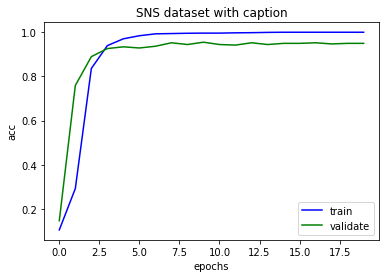

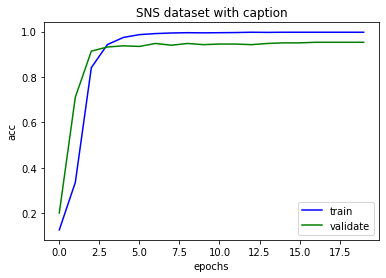

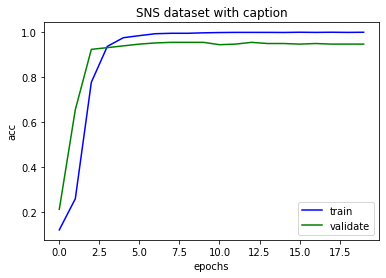

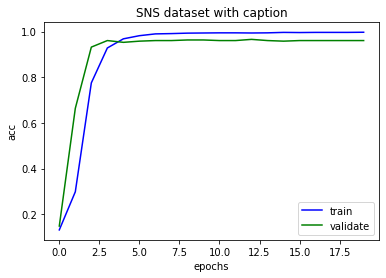

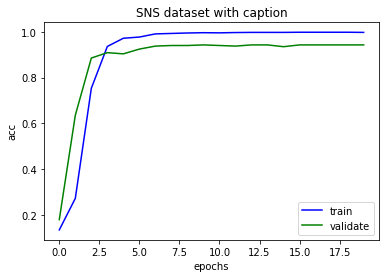

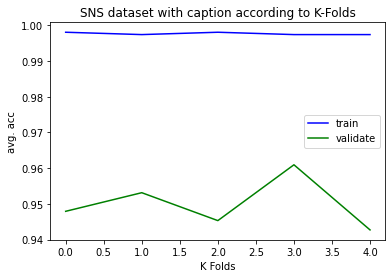

In [ ]:
# groups = np.array([random.randint(0,6) for i in range(0,600)])
# gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
skf = StratifiedKFold(n_splits=n_splits)
#StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
nsplit =0
oldaccu = 0.0
trainarray = []
testarray =[]
# for trainidx, testidx in gss.split(np_data, np_label, groups=groups):
for trainidx,testidx in skf.split(np_data,np_label):
  # print("TRAIN:", trainidx, "TEST:", testidx)
  x_train,x_test,y_train,y_test = np_data[trainidx],np_data[testidx],np_label[trainidx],np_label[testidx]
  # print(x_train)
  # print(x_test)
  # print("%s %s" % (trainidx,testidx))
  data_train = BERTDataset(x_train, 1, 0, tok, max_len, True, False)
#   print("trainidx: ", len(trainidx))
#   print("x_train: ", len(x_train))
#   print("data_train: ", len(data_train))
  data_test = BERTDataset(x_test, 1, 0, tok, max_len, True, False)
  train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers) # before the num_workers = 5
  test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)  
  # load the initial model parameters
  checkpoint = torch.load('kobert.pt')
  model.load_state_dict(checkpoint['modelA'])
  optimizer.load_state_dict(checkpoint['optimizerA'])
  model.to(device)

  t_total = len(train_dataloader) * num_epochs
  warmup_step = int(t_total * warmup_ratio)
  scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)
  trainacclist =[]
  testacclist =[]
  # model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
  # optimizer.step()
  # print("train_dataloader: ", len(train_dataloader))
 
  for e in range(num_epochs):
      train_acc = 0.0
      test_acc = 0.0
      model.train()
      for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
          optimizer.zero_grad()
          token_ids = token_ids.long().to(device)
          segment_ids = segment_ids.long().to(device)
          valid_length= valid_length
          label = label.long().to(device)
          out = model(token_ids, valid_length, segment_ids)
          loss = loss_fn(out, label)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
          optimizer.step()
          scheduler.step()  # Update learning rate schedule
          train_acc += calc_accuracy(out, label)
          if batch_id % log_interval == 0:
              # print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
              print('Epoch {}/{} Batch {}/{} Cost: {:.6f} Train Acc {}'.format(e+1, num_epochs, batch_id+1, len(train_dataloader), loss.item(), train_acc / (batch_id+1)))
#       print("batch id: ", batch_id)
#       print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
      print('\nEpoch {}/{} Cost: {:.6f} Train Acc {}'.format(e+1, num_epochs, loss.item(), train_acc / len(train_dataloader)))
      trainacclist.append(train_acc / (batch_id+1))
      model.eval()
      for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
          token_ids = token_ids.long().to(device)
          segment_ids = segment_ids.long().to(device)
          valid_length= valid_length
          label = label.long().to(device)
          out = model(token_ids, valid_length, segment_ids)
          test_acc += calc_accuracy(out, label)
      # print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
      print('\nEpoch {}/{} Cost: {:.6f} Test Acc {}'.format(e+1, num_epochs, loss.item(), test_acc / len(test_dataloader)))
      testacclist.append(test_acc / (batch_id+1))
      newaccu = test_acc / (batch_id+1)
      if newaccu > oldaccu:
        oldaccu = newaccu
        torch.save(model, model_name)
      gc.collect()  
  plt.figure()
  print(trainacclist)
  trainarray.append(trainacclist[-1])
  print(testacclist)
  testarray.append(testacclist[-1])
  x = np.arange(len(trainacclist))
  plt.plot(x,trainacclist,'b',label='train')
  plt.plot(x,testacclist,'g',label='validate')
  # plt.axis('equal')
  plt.xlabel('epochs')
  plt.ylabel('acc')
  plt.title('SNS dataset with caption')
  # plt.setp(lines, color='r', linewidth=2.0)
  plt.legend()
  plt.savefig('{}.png'.format(nsplit),format='png')
  nsplit +=1

plt.figure()
x = np.arange(len(trainarray))
plt.plot(x,trainarray,'b',label='train')
plt.plot(x,testarray,'g',label='validate')
# plt.axis('equal')
plt.xlabel('K Folds')
plt.ylabel('avg. acc')
plt.title('SNS dataset with caption according to K-Folds')
# plt.setp(lines, color='r', linewidth=2.0)
plt.legend()
plt.savefig('{}.png'.format(nsplit),format='png')
nsplit +=1

print(np.array(trainarray))
print(np.array(testarray))

# pd.DataFrame(np.array(trainarray)).to_csv('trainaccu.csv')
# pd.DataFrame(np.array(testarray)).to_csv('testaccu.csv')

In [ ]:
def precision_at_K (X,Y,K, np_testdata):
  max_vals1,max_indicesK = torch.topk(X,K)
  # print(max_indicesK)
  precisionnum = 0
  index = 0
  for yi, maxindicesi in zip(Y,max_indicesK):
    precisionnum += yi in maxindicesi
    if yi != maxindicesi:
        print("")
        print(yi, maxindicesi)
        print(np_testdata[index])
        print("")
    index += 1
  
  #maxlength = max_indicesK.size()[0] #precision_acc
  return precisionnum

In [ ]:
data_test = BERTDataset(np_testdata, 1, 0, tok, max_len, True, False)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=num_workers) 
gc.collect()
from sklearn.metrics import confusion_matrix

# tensor = torch.ones(())
# wholelabel =tensor.new_empty()
# wholeout =tensor.new_empty()
wholelabel =[]
wholeout =[]
categorylist = ["화장품","패션","요리음식","여행아웃도어","인테리어","엔터테인먼트","육아","아이티","자동차","헬스/피트니스","반려동물"]
modelbest = torch.load(model_name)
modelbest.to(device)
modelbest.eval()
precision_at_3 =0.0
test_acc1 =0.0
start = 0
end = start + batch_size
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = modelbest(token_ids, valid_length, segment_ids)
        labellist = [categorylist[labeli] for labeli in label]
        outlist = [categorylist[outi.argmax()] for outi in out]
        wholelabel+=labellist
        wholeout+=outlist
        test_acc1 += calc_accuracy(out, label)
        precision_at_3 += precision_at_K (out,label,1, np_testdata[start:end])
        start += batch_size
        end = start + batch_size

# print(test_acc1*(batch_id+1)/len(data_test))
print(precision_at_3)
# print(totallength)
print((len(data_test)))
print("Total Acc", precision_at_3/len(data_test))
confusion_matrix(wholelabel, wholeout,labels= categorylist)
np.save('confusionmatrix',confusion_matrix(wholelabel, wholeout,labels= categorylist))
confusion_matrix(wholelabel, wholeout,labels= categorylist)

  0%|          | 0/80 [00:00<?, ?it/s]


tensor(1, device='cuda:4') tensor([9], device='cuda:4')
[1
 '개월 일 폭풍걸음이 시작되었어요 진짜 아기 크는건 한순간인것 같아요 오늘 하루종일 집을 왔다갔다 마라톤을 하길래 밖에 데리고 나갔다가 신발하나 잡아왔어요 이제 곧 뛰어다니겠죠 쫒아다녀야하니 다음엔 제 운동화 하나 사야겠어요 갑분쇼핑 반스키즈 아기신발']


tensor(1, device='cuda:4') tensor([9], device='cuda:4')
[1
 '매일매일 밀라티브 머메이드 민트 멜로우 화이트는 완벽한 조화 밀라티브 사장님 정말 화가 나려 하네요 이렇게 예쁜 옷 만들기 있어요 감사하게 밀라티브 신상 나오는 날 통장 잔고 확인하기 예쁜 폴웨어 입고 오늘 역사적인 순간을 했다 왜냐하면 오늘 인생 첫 공중에서 인버트하기 수업을 나갔기 때문이다 이게 이렇게 난리 칠 일이야 할 수 있지만 온전히 내 주관적 생각으로 폴댄스의 꽃은 에어인버트가 아닐까 생각한다 폴을 처음 탈때부터 공중 곡예사가 돼고 싶단 꿈을 갖고 있었기 때문에 더 열심히 하고 싶단 배움의 욕심이 생기기 시작했다 괴발개발 아닌 예쁘게 활짝 핀 인버트로 멋진 폴링 할 수 있을 때까지 힘 짱이 되어 보자 폴웨어 폴댄스 운동 운동복 폴복 폴키니 포사폴아트코리아 폴리쉬 대전 대전폴댄스 밀라폴댄스 대전폴댄스는밀라폴댄스']


tensor(2, device='cuda:4') tensor([0], device='cuda:4')
[2
 '더비나인 샘플 체험 프로모션 더비나인 화이트뱅쇼 상그리아 샘플 키트를 쏩니다 샘플 개로 따뜻하고 향긋한 뱅쇼 또는 상큼하고 달콤한 시원한 상그리아 잔을 뚝딱 만들 수 있어요 당첨 경품 더비나인 화이트뱅쇼 상그리아 샘플 키트 신청 방법 더비나인 인스타그램을 팔로우 한다 화이트뱅쇼 상그리아를 만들어 같이 먹어보고 싶은 사람을 댓글로 태그한다 친구야 같이 먹자 당첨 인원 명 이벤트 기간 화 월 당첨자 발표 화 당첨되신 분들께는 발송 드립니다 더비나인 이벤트 프로모션 

array([[43,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 39,  0,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 1,  0, 75,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 45,  2,  2,  0,  0,  0,  1,  0],
       [ 0,  1,  0,  0, 39,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 27,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  0,  0,  0, 39,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 37,  0,  0,  1],
       [ 0,  0,  0,  1,  0,  0,  0,  0, 39,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 41,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  1, 39]])

In [ ]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, notebook

from torch.nn import init
import gc
import unicodedata
import re

import requests
import pprint
import json

import sys

class BERTDataset(Dataset):
    def __init__(self, data, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = []

        if len(data)<=max_len:
            self.sentences.append(transform([data]))
        else:
            self.sentences.append(transform([data[:max_len]]))


    def __getitem__(self, i):
        return (self.sentences[i])

    def __len__(self):
        return (len(self.sentences))

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=11,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)
def GetMediaCategory(text):
    text = unicodedata.normalize('NFC',text)
    text = ' '.join(re.compile('[가-힣]+').findall(text))
    if len(text) == 0:
        text = '기타'

    #datalist = BERTDataset(captionlist,tok, max_len, True, False)
    data = BERTDataset(text, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=num_workers)
    gc.collect()
    wholeout=[]
    wholevalue=[]
    # for (token_ids, valid_length, segment_ids) in datalist:
    for batch_id,(token_ids, valid_length, segment_ids) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        outlist = []
        valuelist = []
        out = modelbest(token_ids, valid_length, segment_ids)
        for outi in out:
            valuelist.append(outi.max().tolist())
            if outi.max().tolist() > threshold:
                outlist.append(categorylist[outi.argmax()])
            else:
                outlist.append('기타')
        wholeout+=outlist
        wholevalue+=valuelist

    return wholeout, wholevalue

############################################################################
############################################################################
############################################################################

##GPU 사용 시
# there are totally five GPU in server,we can routed to 0:4.
# device = torch.device("cuda:0")
device = torch.device('cpu')

##CPU 사용 시
# device = torch.device('cpu')
gc.collect()

bertmodel, vocab = get_pytorch_kobert_model()
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

# define parameter
max_len = 512
batch_size = 6
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 20
learning_rate =  5e-6  #5e-5  2e-5
num_workers = 2
n_splits = 5
model_name = 'kobertbest_512.pt'

categorylist = ["화장품","패션","요리음식","여행아웃도어","인테리어","엔터테인먼트","육아","아이티","자동차","헬스/피트니스","반려동물"]
threshold = 5.26

modelbest = torch.load("/home/ec2-user/ipc_partners_influencer_specialty/" + model_name, map_location=device)
modelbest.to(device)
modelbest.eval()

text = sys.argv[1]

classlist, valuelist = GetMediaCategory(text)
print(sys.argv[1])
print(classlist)
print(valuelist)
with open("/home/ec2-user/ipc_partners_influencer_specialty/result.txt", "w") as f:
    f.write(classlist[0])
    f.write(' ' + str(valuelist[0]))

#return 'test'

